# Proteomics Data Analysis Workflow

This notebook combines several analysis steps for proteomics data. 

The notebook has three parts:
1. Proteomics Statistics:  
    1.1. Analysis of the share of detected locus tags  
    1.2. Coverage per detected protein  
    1.3. Clustering of undetected proteins (e.g are they primarily membrane / secondary metabolite related)  
2. Whole Proteome Analysis:   
    2.1. Identification of shared core-proteome across all samples  
    2.2. Whole proteome correlation  
    2.3. Clustermap of all samples  
    2.4. T-Test of each control / sample combination  
    2.5. Plotting of clustermap for p-values < 0.05 / 0.005  
    2.6. COG Annotation of significantly changed locus tags  

        

## 0. Load Modules and Specify Directories

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import display, HTML
import seaborn as sns
from Bio import SeqIO

/Users/chrwhi/Software/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : None
python           : 3.7.4.final.0
python-bits      : 64
OS               : Darwin
OS-release       : 22.1.0
machine          : x86_64
processor        : i386
byteorder        : little
LC_ALL           : en_US.UTF-8
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 1.0.3
numpy            : 1.17.2
pytz             : 2019.3
dateutil         : 2.8.0
pip              : 19.2.3
setuptools       : 41.4.0
Cython           : 0.29.13
pytest           : 5.2.1
hypothesis       : None
sphinx           : 2.2.0
blosc            : None
feather          : None
xlsxwriter       : 1.2.1
lxml.etree       : 4.4.1
html5lib         : 1.0.1
pymysql          : None
psycopg2         : None
jinja2           : 2.10.3
IPython          : 7.8.0
pandas_datareader: None
bs4              : 4.8.0
bottleneck       : 1.2.1
fastparquet      : None
gcsfs            : None
lxml.etree       : 4.4.1
matplotlib       : 3.3.3
numexpr    

In [12]:
#Directory Specification

#define directory that contains the proteomics results
proteomics_dir = " " 

#define directory for results (optional, but useful when analyzing different data sets)
sub_dir ="Analysis_BE/" 

#give your data set a name 
data_name = "MCBE_BE_data"

#Specify reference proteome file in .fasta format
reference = proteomics_dir + "01_CFB_NBC001_proteome.fasta"

#Extract all locus tags from the reference file 
locus_tags_list = []
for record in SeqIO.parse(reference, "fasta"):
    locus_tags_list.append(record.id)

locus_tags_complete = pd.DataFrame(locus_tags_list, columns=['Locus_Tag'])

#Load the proteomics data
proteome_data = pd.read_excel("")


# Drop columns not of interest
columns_drop = ["Checked", "Protein FDR Confidence: Combined", "Master"]
proteome_data.drop(columns=columns_drop, inplace = True)

## 1. Proteomics Statistics

This script takes a given proteomics output file and generates general statistics.

1.1 What percentage of locus tags were detected

1.2 Grouping of undetected locus tags --> are there any specific gene classifications that stand out (e.g membrane proteins)

1.3 Identification of the shared detected proteome across samples and plotting of Venn diagramms

### 1.1 What percantage of locus tags was detected? 

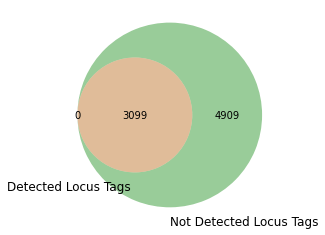

In [16]:
#This data shows how many locus tags were detected across the entire data set. For sample specific data, check next cell. 

#import package for venn diagramm
from matplotlib_venn import venn2

#Extract all detected locus tags from proteome data frame
locus_tags_all_detected = proteome_data['Accession'].tolist()

#remove all entries that do not have a locus tag (peptides from the sample prep/contaminations)
locus_tags_all_detected[:] = [x for x in locus_tags_all_detected if x.startswith('FQ762')]

#turn list into data frame
locus_tags_all_detected_df = pd.DataFrame(locus_tags_all_detected, columns=['Locus_Tag'])

#Create Venn Diagramm
venn2([set(locus_tags_all_detected_df['Locus_Tag']),
           set(locus_tags_complete['Locus_Tag'])],
           set_labels=("Detected Locus Tags ","Not Detected Locus Tags"))

#Save in result dir if wanted
#plt.savefig(proteomics_dir + sub_dir + "Venn_" + data_name+".svg", bbox_inches='tight')
plt.show()

In [17]:
#Analysis of sample specific number of detected locus tags 

#Define sample IDs/names of interest
sample_IDs = ["MC01_Proteo1", "MC02_Proteo1","MC03_Proteo1","MC01_Proteo2","MC02_Proteo2","MC03_Proteo2", "MC04_Proteo1","MC05_Proteo1","MC06_Proteo1","MC04_Proteo2","MC05_Proteo2","MC06_Proteo2","MC07_Proteo2","MC08_Proteo2","MC09_Proteo2","MC07_Proteo3","MC08_Proteo3","MC09_Proteo3","MC10_Proteo1","MC11_Proteo1","MC12_Proteo1","MC10_Proteo2","MC11_Proteo2","MC12_Proteo2"]
#sample_IDs = ["MC13_Proteo1_di","MC14_Proteo1_di","MC15_Proteo1_di","MC16_Proteo1_di","MC17_Proteo1_di","MC18_Proteo1_di","MC19_Proteo2_di","MC20_Proteo2_di","MC21_Proteo2_di","MC13_Proteo2_di","MC14_Proteo2_di","MC15_Proteo2_di","MC16_Proteo2_di","MC17_Proteo2_di","MC18_Proteo2_di","MC19_Proteo3_di","MC20_Proteo3_di","MC21_Proteo3_di"]

#Extract column names for downstream analysis based on the sample IDs
proteome_col = list(proteome_data.columns)
columns_samples = []
columns_samples_numerical = ['Accession']
for i in sample_IDs:
    for l in proteome_col:
        if l.startswith("Abundances"):
            if i in l:
                columns_samples.append(l)
                columns_samples_numerical.append(l)

total_locus_tags = len(locus_tags_complete.index) #total number of locus tags

sample_stats = pd.DataFrame(columns=columns_samples, index=["Locus Tags Detected", "Missing Locus Tags", "Percentage Detected"])

#Extract number of detected locus tags for each sample
for i in columns_samples:
    sample_stats[i]["Locus Tags Detected"] = len(proteome_data[i].dropna().index)
    sample_stats[i]["Missing Locus Tags"] = int(total_locus_tags - len(proteome_data[i].dropna().index))
    sample_stats[i]["Percentage Detected"] = len(proteome_data[i].dropna().index)/total_locus_tags
    
#Save dataframe as csv
#sample_stats.to_csv(proteomics_dir+sub_dir+data_name+"detection_stats"+".csv")
sample_stats


,Abundances (Normalized): MC01_Proteo1 Sample,Abundances (Normalized): MC02_Proteo1 Sample,Abundances (Normalized): MC03_Proteo1 Sample,Abundances (Normalized): MC01_Proteo2 Sample,Abundances (Normalized): MC02_Proteo2 Sample,Abundances (Normalized): MC03_Proteo2 Sample,Abundances (Normalized): MC04_Proteo1 Sample,Abundances (Normalized): MC05_Proteo1 Sample,Abundances (Normalized): MC06_Proteo1 Sample,Abundances (Normalized): MC04_Proteo2 Sample,...,Abundances (Normalized): MC09_Proteo2 Sample,Abundances (Normalized): MC07_Proteo3 Sample,Abundances (Normalized): MC08_Proteo3 Sample,Abundances (Normalized): MC09_Proteo3 Sample,Abundances (Normalized): MC10_Proteo1 Sample,Abundances (Normalized): MC11_Proteo1 Sample,Abundances (Normalized): MC12_Proteo1 Sample,Abundances (Normalized): MC10_Proteo2 Sample,Abundances (Normalized): MC11_Proteo2 Sample,Abundances (Normalized): MC12_Proteo2 Sample
Locus Tags Detected,2792,2763,2765,2815,2731,2757,2714,2750,2789,2790,...,2782,2803,2798,2804,2726,2682,2707,2767,2767,2768
Missing Locus Tags,5216,5245,5243,5193,5277,5251,5294,5258,5219,5218,...,5226,5205,5210,5204,5282,5326,5301,5241,5241,5240
Percentage Detected,0.348651,0.34503,0.34528,0.351523,0.341034,0.344281,0.338911,0.343407,0.348277,0.348402,...,0.347403,0.350025,0.349401,0.35015,0.34041,0.334915,0.338037,0.345529,0.345529,0.345654


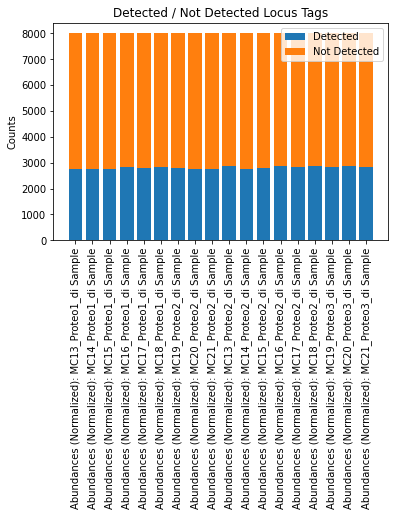

In [6]:
#Optional plotting of the detection stats
fig, ax = plt.subplots()

labels = sample_stats.columns

ax.bar(labels, sample_stats.loc["Locus Tags Detected"],  label='Detected')
ax.bar(labels, sample_stats.loc["Missing Locus Tags"], bottom=sample_stats.loc["Locus Tags Detected"],label='Not Detected')

ax.set_ylabel('Counts')
ax.set_title('Detected / Not Detected Locus Tags')
ax.legend()
plt.xticks(rotation=90)

plt.show()

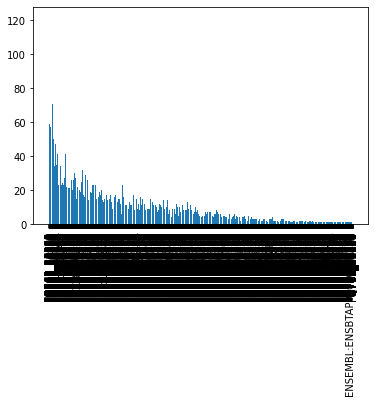

In [7]:
#Plotting peptide coverage per protein
fig, ax = plt.subplots()
ax.bar(proteome_data["Accession"],proteome_data["# Peptides"])
plt.xticks(rotation=90)

plt.show()

In [9]:
peptides = proteome_data.set_index("Accession")["# Peptides"].sort_values()

#Optional: Export peptide counts
peptides.to_csv(proteomics_dir+sub_dir+data_name+"peptide_stats"+".csv")

### 1.2 Grouping and Analysis of undetected locus tags

In [18]:

#empty data frame for absence presence matrix 
locus_presence = pd.DataFrame()

#Create boolean matrix of proteome data based on whether a cell is NaN ("Not a Number"), meaning no peptide detected for the given locus tag
proteome_data_na = proteome_data.set_index('Accession').isna()
proteome_data_na.index

#go through boolean matrix and turn NaNs into 0, everything else into 1. 0 indicates absence, 1 presence
for i in columns_samples:
    for l in locus_tags_complete['Locus_Tag'].tolist():
        if l in locus_tags_all_detected_df['Locus_Tag'].tolist():
            if proteome_data_na[i][l] == True:
                locus_presence.at[l, i] = 0
            elif proteome_data_na[i][l] == False:
                locus_presence.at[l, i] = 1
        else:
            locus_presence.at[l,i] = 0

#Optional: Save absence/presence matrix
locus_presence.sort_index().to_csv(proteomics_dir+sub_dir+data_name+"absence_presence_matrix"+".csv")
display(locus_presence.sort_index())

,Abundances (Normalized): MC01_Proteo1 Sample,Abundances (Normalized): MC02_Proteo1 Sample,Abundances (Normalized): MC03_Proteo1 Sample,Abundances (Normalized): MC01_Proteo2 Sample,Abundances (Normalized): MC02_Proteo2 Sample,Abundances (Normalized): MC03_Proteo2 Sample,Abundances (Normalized): MC04_Proteo1 Sample,Abundances (Normalized): MC05_Proteo1 Sample,Abundances (Normalized): MC06_Proteo1 Sample,Abundances (Normalized): MC04_Proteo2 Sample,...,Abundances (Normalized): MC09_Proteo2 Sample,Abundances (Normalized): MC07_Proteo3 Sample,Abundances (Normalized): MC08_Proteo3 Sample,Abundances (Normalized): MC09_Proteo3 Sample,Abundances (Normalized): MC10_Proteo1 Sample,Abundances (Normalized): MC11_Proteo1 Sample,Abundances (Normalized): MC12_Proteo1 Sample,Abundances (Normalized): MC10_Proteo2 Sample,Abundances (Normalized): MC11_Proteo2 Sample,Abundances (Normalized): MC12_Proteo2 Sample
FQ762_00005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FQ762_00010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FQ762_00015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FQ762_00020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FQ762_00025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FQ762_40445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FQ762_40450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FQ762_40455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FQ762_40460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
## 

In [19]:
#Define sample sets --> Samples that should be compared/plotted together
#Set 1
#sample_IDs = ["MC01_Proteo1","MC02_Proteo1","MC03_Proteo1","MC04_Proteo1","MC05_Proteo1","MC06_Proteo1","MC07_Proteo2","MC08_Proteo2","MC09_Proteo2","MC10_Proteo1","MC11_Proteo1","MC12_Proteo1"]
#Set2
#sample_IDs = ["MC01_Proteo2","MC02_Proteo2","MC03_Proteo2","MC04_Proteo2","MC05_Proteo2","MC06_Proteo2","MC07_Proteo3","MC08_Proteo3","MC09_Proteo3","MC10_Proteo2","MC11_Proteo2","MC12_Proteo2"]
#Set 3
#sample_IDs = ["MC13_Proteo1_di","MC14_Proteo1_di","MC15_Proteo1_di","MC16_Proteo1_di","MC17_Proteo1_di","MC18_Proteo1_di","MC19_Proteo2_di","MC20_Proteo2_di","MC21_Proteo2_di"]
#Set 4
#sample_IDs = ["MC13_Proteo2_di","MC14_Proteo2_di","MC15_Proteo2_di","MC16_Proteo2_di","MC17_Proteo2_di","MC18_Proteo2_di","MC19_Proteo3_di","MC20_Proteo3_di","MC21_Proteo3_di"]
#Set3+4
#sample_IDs = ["MC13_Proteo1_di","MC14_Proteo1_di","MC15_Proteo1_di","MC16_Proteo1_di","MC17_Proteo1_di","MC18_Proteo1_di","MC19_Proteo2_di","MC20_Proteo2_di","MC21_Proteo2_di","MC13_Proteo2_di","MC14_Proteo2_di","MC15_Proteo2_di","MC16_Proteo2_di","MC17_Proteo2_di","MC18_Proteo2_di","MC19_Proteo3_di","MC20_Proteo3_di","MC21_Proteo3_di"]
#Set1+2
sample_IDs = ["MC01_Proteo1","MC02_Proteo1","MC03_Proteo1","MC04_Proteo1","MC05_Proteo1","MC06_Proteo1","MC07_Proteo2","MC08_Proteo2","MC09_Proteo2","MC10_Proteo1","MC11_Proteo1","MC12_Proteo1","MC01_Proteo2","MC02_Proteo2","MC03_Proteo2","MC04_Proteo2","MC05_Proteo2","MC06_Proteo2","MC07_Proteo3","MC08_Proteo3","MC09_Proteo3","MC10_Proteo2","MC11_Proteo2","MC12_Proteo2"]


#Extract the columns of interest
columns_samples_numerical = [] 
columns_samples_numerical_prot = ["Accession"] #add 'Accession' when working with proteome_samples df
for i in sample_IDs:
    for l in proteome_col:
        if l.startswith("Abundances"):
            if i in l:
                columns_samples_numerical.append(l)
                columns_samples_numerical_prot.append(l)

locus_presence_samples = locus_presence[columns_samples_numerical]
proteome_data_samples = proteome_data[columns_samples_numerical_prot].set_index('Accession')

locus_presence_samples
proteome_data_samples.to_csv(proteomics_dir+sub_dir+data_name+"_proteome_data_samples_t2"+".csv")
proteome_data_samples

,Abundances (Normalized): MC01_Proteo1 Sample,Abundances (Normalized): MC02_Proteo1 Sample,Abundances (Normalized): MC03_Proteo1 Sample,Abundances (Normalized): MC04_Proteo1 Sample,Abundances (Normalized): MC05_Proteo1 Sample,Abundances (Normalized): MC06_Proteo1 Sample,Abundances (Normalized): MC07_Proteo2 Sample,Abundances (Normalized): MC08_Proteo2 Sample,Abundances (Normalized): MC09_Proteo2 Sample,Abundances (Normalized): MC10_Proteo1 Sample,...,Abundances (Normalized): MC03_Proteo2 Sample,Abundances (Normalized): MC04_Proteo2 Sample,Abundances (Normalized): MC05_Proteo2 Sample,Abundances (Normalized): MC06_Proteo2 Sample,Abundances (Normalized): MC07_Proteo3 Sample,Abundances (Normalized): MC08_Proteo3 Sample,Abundances (Normalized): MC09_Proteo3 Sample,Abundances (Normalized): MC10_Proteo2 Sample,Abundances (Normalized): MC11_Proteo2 Sample,Abundances (Normalized): MC12_Proteo2 Sample
Accession,,,,,,,,,,,,,,,,,,,,,
FQ762_24085,1.171586e+09,1.107951e+09,1.085799e+09,8.397252e+08,8.831024e+08,8.870422e+08,1.742838e+09,1.894844e+09,1.843363e+09,1.101435e+09,...,8.332682e+08,8.532477e+08,8.696870e+08,9.037809e+08,1.539099e+09,1.565285e+09,1.542599e+09,1.017561e+09,1.117278e+09,1.060976e+09
FQ762_24080,9.569938e+08,9.242977e+08,8.896606e+08,7.269815e+08,7.292593e+08,7.393495e+08,1.538613e+09,1.613691e+09,1.574196e+09,9.288558e+08,...,6.943140e+08,7.134240e+08,7.314466e+08,7.728698e+08,1.317006e+09,1.355001e+09,1.331623e+09,8.526796e+08,9.539871e+08,8.815348e+08
FQ762_27290,6.384761e+08,6.165301e+08,6.170672e+08,5.991847e+08,5.976254e+08,6.193623e+08,9.259152e+08,9.932674e+08,9.615943e+08,6.992379e+08,...,6.147268e+08,6.472840e+08,6.723428e+08,6.844034e+08,9.999289e+08,1.027562e+09,1.025154e+09,7.108583e+08,7.997206e+08,7.721618e+08
FQ762_16075,6.479556e+08,6.373093e+08,6.237242e+08,6.317717e+08,6.506322e+08,6.349711e+08,5.915943e+08,6.033881e+08,5.977442e+08,9.246726e+08,...,7.056409e+08,6.821330e+08,7.251131e+08,7.157364e+08,8.438576e+08,8.824270e+08,8.804646e+08,1.006729e+09,1.143494e+09,1.056634e+09
FQ762_11145,4.028639e+08,4.006740e+08,3.793118e+08,3.179372e+08,3.382410e+08,3.537483e+08,4.515330e+08,4.696944e+08,4.602387e+08,1.338808e+09,...,3.402384e+08,3.383388e+08,3.583782e+08,3.494747e+08,4.628978e+08,4.564082e+08,4.707294e+08,1.219885e+09,1.392688e+09,1.332704e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FQ762_26965,1.672995e+06,1.565424e+06,1.542756e+06,1.396169e+06,1.378737e+06,1.508704e+06,2.156559e+06,2.256712e+06,2.143512e+06,1.610014e+06,...,1.213512e+06,1.437787e+06,1.271606e+06,1.213706e+06,2.127784e+06,2.017837e+06,2.061343e+06,1.462316e+06,1.543806e+06,1.398290e+06
FQ762_22695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FQ762_22970,3.616373e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#To cluster undetected locus tags, COG categories are used. Requires both a COG annotation table with the single letter codes and categories, and a COG annotation of the reference genome

#File path to COG annotation table 
COG_categories = pd.read_csv("COG_Categories.csv", delimiter=';').set_index("COG Group")

#File path to COG annotation of the reference genome
coelicolor_COG = pd.read_csv("Scoelicolor_COG_annotations.csv",sep=";").set_index("query")

coelicolor_COG
COG_categories

,Description
COG Group,
A,RNA processing and modification
B,Chromatin Structure and dynamics
C,Energy production and conversion
D,Cell cycle control and mitosis
E,Amino Acid metabolis and transport
F,Nucleotide metabolism and transport
G,Carbohydrate metabolism and transport
H,Coenzyme metabolis
I,Lipid metabolism


In [13]:
#Annotate locus tags that were not detected across the entire data set

#extract undetected locus tags
undetected_locustags = []
for i in locus_tags_complete["Locus_Tag"].tolist():
    if i in locus_tags_all_detected_df["Locus_Tag"].tolist():
        continue
    else:
        undetected_locustags.append(i)
        
#Create dataframe of undetected locustags
undetected_locustags_df = pd.DataFrame(undetected_locustags, columns = ["Locus_Tag"])
undetected_locustags_df["COG_category"] = 1
undetected_locustags_df = undetected_locustags_df.set_index("Locus_Tag")

#annotate undetected locus tags with COG categories and descriptions
# 1) COG categories
for i in undetected_locustags_df.index:
    if i in coelicolor_COG.index:
        undetected_locustags_df["COG_category"].loc[i] =  coelicolor_COG["COG_category"].loc[i]
    else:
        undetected_locustags_df["COG_category"].loc[i] = "not detected" #not detected means the locus tag is not in the COG annotation

# 2) COG descriptions
undetected_locustags_df["Description"] = "-"
for i in undetected_locustags_df["COG_category"].tolist():
    if not i == '-':
        if len(i) == 1: #if len = 1 only one COG category
            undetected_locustags_df["Description"][undetected_locustags_df["COG_category"] == i] = COG_categories["Description"].loc[i]
        elif len(i) > 1 and i != "not detected": #if len > 1 more than one COG category
            descript = []
            for l in list(i): #extract all descriptions for the categories
                descript.append(COG_categories["Description"].loc[l])  
            undetected_locustags_df["Description"][undetected_locustags_df["COG_category"] == i] = ','.join(descript)
    else:
        continue

undetected_locustags_df.groupby("COG_category").count()

,Description
COG_category,
-,794
A,2
ADL,1
B,1
C,192
...,...
T,236
TV,1
U,23


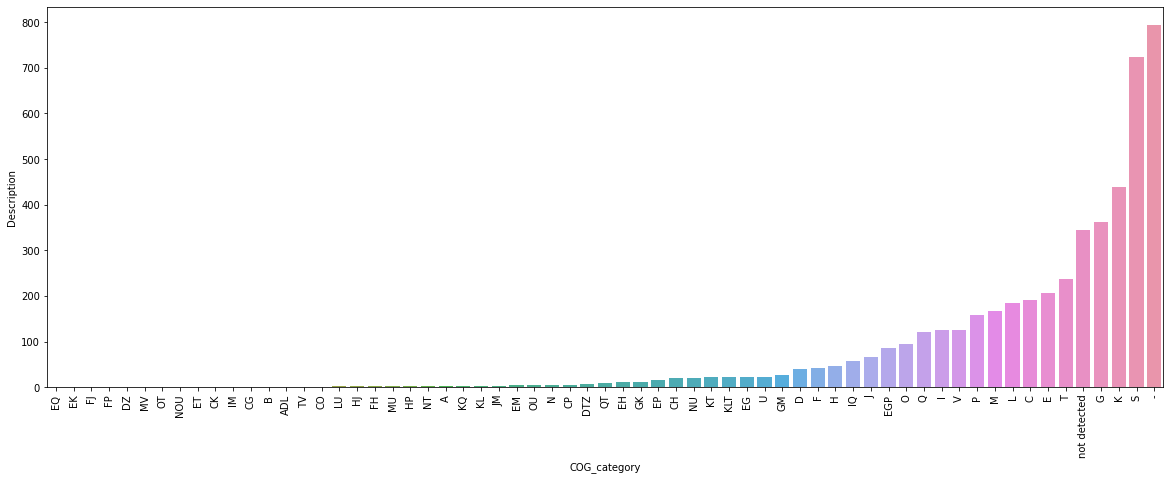

In [14]:
#Count occurence of each COG category through groupby and count and perform sorting 
undetected_locustags_df_counts = undetected_locustags_df.groupby("COG_category").count().sort_values(by=['Description'])
undetected_locustags_df_counts.to_csv(proteomics_dir+sub_dir+data_name+"_undetected_locustags_COG_t2"+".csv")

#plotting of COG category counts of undetected locus tags
fig, ax = plt.subplots(figsize=(20,7)) 
ax = sns.barplot(x=undetected_locustags_df_counts.index, y="Description", data=undetected_locustags_df_counts)
plt.xticks(rotation=90)
plt.show()

## 2. Whole Proteome Analysis

### 2.1. Identification of shared proteome data across all samples

All analysis regarding whole proteome correlation is performed with the shared proteome across the entire sample space

In [33]:
#Identification of shared proteome data

shared_proteome_detected = locus_presence_samples.loc[(locus_presence_samples==1).all(axis=1)]
core_data = proteome_data_samples[proteome_data_samples.index.isin(shared_proteome_detected.index)]

#Optional export to csv
core_data.to_csv(proteomics_dir+sub_dir+data_name+"core_data_time_point2"+".csv")

core_data

,Abundances (Normalized): MC13_Proteo2_di Sample,Abundances (Normalized): MC14_Proteo2_di Sample,Abundances (Normalized): MC15_Proteo2_di Sample,Abundances (Normalized): MC16_Proteo2_di Sample,Abundances (Normalized): MC17_Proteo2_di Sample,Abundances (Normalized): MC18_Proteo2_di Sample,Abundances (Normalized): MC19_Proteo3_di Sample,Abundances (Normalized): MC20_Proteo3_di Sample,Abundances (Normalized): MC21_Proteo3_di Sample
Accession,,,,,,,,,
FQ762_24085,1.565191e+09,1.539403e+09,1.558302e+09,1.621189e+09,1.706793e+09,1.587041e+09,1.425646e+09,1.424577e+09,1.316643e+09
FQ762_24080,1.333856e+09,1.372496e+09,1.362016e+09,1.390068e+09,1.390743e+09,1.366475e+09,1.233834e+09,1.222607e+09,1.140707e+09
FQ762_27290,1.073218e+09,1.043110e+09,1.075693e+09,1.206569e+09,1.219965e+09,1.154348e+09,1.121177e+09,1.125578e+09,1.078252e+09
FQ762_16075,1.010895e+09,8.888453e+08,9.998728e+08,1.349805e+09,1.304110e+09,1.258194e+09,1.160034e+09,1.110536e+09,1.081192e+09
FQ762_22215,9.433617e+09,9.549136e+09,9.445389e+09,1.053353e+10,1.070477e+10,1.068618e+10,1.031709e+10,1.011135e+10,1.038987e+10
...,...,...,...,...,...,...,...,...,...
FQ762_31105,2.141917e+06,1.791110e+06,2.476166e+06,1.857087e+06,1.854378e+06,1.986184e+06,1.787656e+06,2.149359e+06,2.210844e+06
FQ762_00415,1.380519e+06,9.060811e+05,1.139104e+06,1.103899e+06,8.750006e+05,1.031775e+06,1.266539e+06,9.820346e+05,9.487480e+05
FQ762_00920,2.095208e+07,2.354512e+07,2.087075e+07,1.358577e+07,1.375323e+07,1.560903e+07,1.665474e+07,1.722720e+07,1.591190e+07


In [16]:
core_data.loc["FQ762_07815"]

Abundances (Normalized): MC13_Proteo2_di Sample    2.860449e+07
Abundances (Normalized): MC14_Proteo2_di Sample    2.879018e+07
Abundances (Normalized): MC15_Proteo2_di Sample    2.807908e+07
Abundances (Normalized): MC16_Proteo2_di Sample    2.643666e+07
Abundances (Normalized): MC17_Proteo2_di Sample    2.452489e+07
Abundances (Normalized): MC18_Proteo2_di Sample    2.534865e+07
Abundances (Normalized): MC19_Proteo3_di Sample    2.850450e+07
Abundances (Normalized): MC20_Proteo3_di Sample    2.860480e+07
Abundances (Normalized): MC21_Proteo3_di Sample    2.937456e+07
Name: FQ762_07815, dtype: float64

### 2.2. Whole proteome correlation

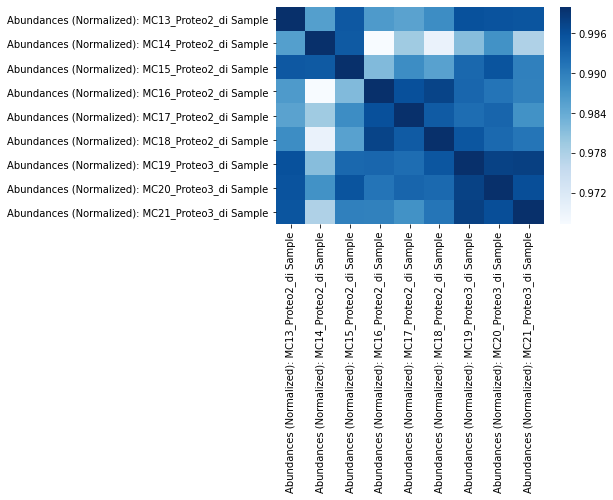

In [18]:
#Plotting of Pearson correlation matrix for the entire data
corr = core_data.corr(method='pearson', min_periods=1)
corr.to_csv(proteomics_dir+sub_dir+data_name+"_whole_proteome_correlation_timpoint2"+".csv")
core_data_corr = sns.heatmap(corr, cmap="Blues")

#Optional: save figure
#row_norm.savefig(proteomics_dir+sub_dir+data_name+"core_Data_correlation_timepoint2"+".png")

plt.show()

### 2.3. Clustermap of all samples

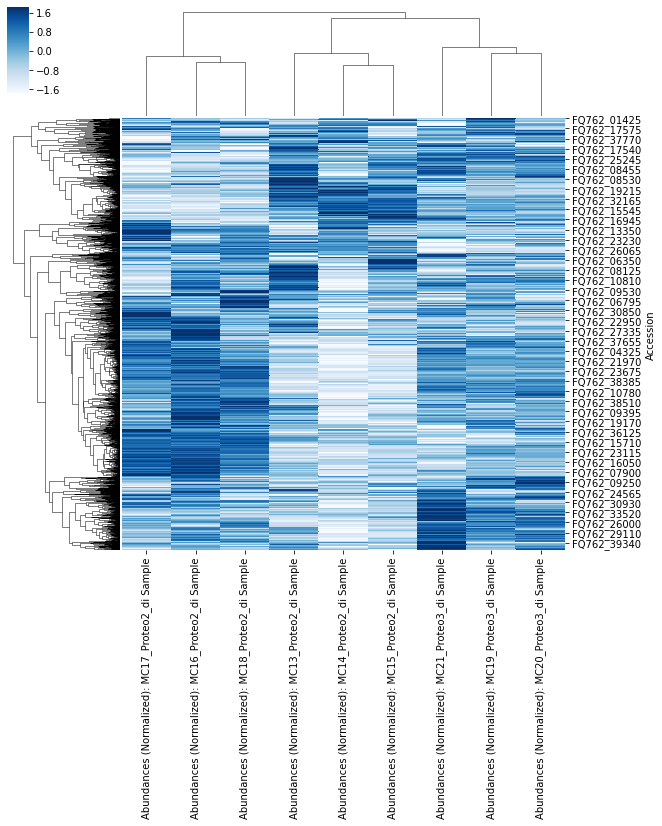

In [19]:
#Plotting of clustermap of core_data with normalization across rows / for each locus tag across all samples 
row_norm = sns.clustermap(core_data,metric='correlation',robust='True',method='average',z_score = 0, cmap='Blues')

#Optional: save figure
row_norm.savefig(proteomics_dir+sub_dir+data_name+"clustermap_row_norm_timepoint2"+".svg")

plt.show()

In [46]:
#CRISPR interference specifc: 

proteome_data_WT = pd.read_csv("/Analysis_BE/MCBE_BE_data_proteome_data_samples.csv").set_index("Accession").dropna(axis = 0, how = 'all')
proteome_data_WT = proteome_data_WT[["Abundances (Normalized): MC01_Proteo2 Sample","Abundances (Normalized): MC02_Proteo2 Sample", "Abundances (Normalized): MC03_Proteo2 Sample" ]]

proteome_CRISPRi_WT = core_data.join(proteome_data_WT, how="outer", lsuffix="_left")
proteome_CRISPRi_WT.loc["FQ762_32170"] #["FQ762_16595","FQ762_26280","FQ762_26985","FQ762_27465","FQ762_29990","FQ762_30470","FQ762_31255","FQ762_31390","FQ762_32170"]

KeyError: 'FQ762_32170'

### 2.4. T-Tests for each control/sample combination

In [16]:
#data structure requires that the controls and sample triplicates are in seperate dataframes. Replace column names with your own sample names
core_data_WT = core_data[['Abundances (Normalized): MC01_Proteo2 Sample','Abundances (Normalized): MC02_Proteo2 Sample','Abundances (Normalized): MC03_Proteo2 Sample']]
core_data_BE9b = core_data[['Abundances (Normalized): MC04_Proteo2 Sample','Abundances (Normalized): MC05_Proteo2 Sample','Abundances (Normalized): MC06_Proteo2 Sample']]
core_data_BE18 = core_data[['Abundances (Normalized): MC07_Proteo3 Sample','Abundances (Normalized): MC08_Proteo3 Sample','Abundances (Normalized): MC09_Proteo3 Sample']]
core_data_BE28 = core_data[['Abundances (Normalized): MC10_Proteo2 Sample','Abundances (Normalized): MC11_Proteo2 Sample','Abundances (Normalized): MC12_Proteo2 Sample']]

core_data_WT = core_data[['Abundances (Normalized): MC01_Proteo2 Sample','Abundances (Normalized): MC02_Proteo2 Sample','Abundances (Normalized): MC03_Proteo2 Sample']]
core_data_BE9b = core_data[['Abundances (Normalized): MC04_Proteo2 Sample','Abundances (Normalized): MC05_Proteo2 Sample','Abundances (Normalized): MC06_Proteo2 Sample']]
core_data_BE18 = core_data[['Abundances (Normalized): MC07_Proteo3 Sample','Abundances (Normalized): MC08_Proteo3 Sample','Abundances (Normalized): MC09_Proteo3 Sample']]
core_data_BE28 = core_data[['Abundances (Normalized): MC10_Proteo2 Sample','Abundances (Normalized): MC11_Proteo2 Sample','Abundances (Normalized): MC12_Proteo2 Sample']]

In [17]:
#import scipy for statistics 
import scipy.stats as stats

#set pvalue to use
pval = 0.005

#create empty dataframes for results
result_ttest_BE9b = pd.DataFrame(columns=["tvalue", "pvalue"], index=core_data.index)
result_ttest_BE18 = pd.DataFrame(columns=["tvalue", "pvalue"], index=core_data.index)
result_ttest_BE28 = pd.DataFrame(columns=["tvalue", "pvalue"], index=core_data.index)

#Perform t-tests for each locus tag
for locus_tag in core_data.index:
    tvalue, pvalue = stats.ttest_ind(
        core_data_WT.loc[[locus_tag]].T, #dataframe with control
        core_data_BE9b.loc[[locus_tag]].T) #dataframe with sample 1
    result_ttest_BE9b["tvalue"].loc[[locus_tag]] = tvalue
    result_ttest_BE9b["pvalue"].loc[[locus_tag]] = pvalue
    
for locus_tag in core_data.index:
    tvalue, pvalue = stats.ttest_ind(
        core_data_WT.loc[[locus_tag]].T, #dataframe with control
        core_data_BE18.loc[[locus_tag]].T) #dataframe with sample 2
    result_ttest_BE18["tvalue"].loc[[locus_tag]] = tvalue
    result_ttest_BE18["pvalue"].loc[[locus_tag]] = pvalue

for locus_tag in core_data.index:
    tvalue, pvalue = stats.ttest_ind(
        core_data_WT.loc[[locus_tag]].T, #dataframe with control
        core_data_BE28.loc[[locus_tag]].T) #dataframe with sample 3
    result_ttest_BE28["tvalue"].loc[[locus_tag]] = tvalue
    result_ttest_BE28["pvalue"].loc[[locus_tag]] = pvalue

#Optional: Save test results
#result_ttest_BE9b.to_csv(proteomics_dir+sub_dir+data_name+"core_data_BE9b_time_point2_t-test_"+ str(pval)+".csv")
#result_ttest_BE18.to_csv(proteomics_dir+sub_dir+data_name+"core_data_BE18_time_point2_t-test_"+str(pval)+".csv")
#result_ttest_BE28.to_csv(proteomics_dir+sub_dir+data_name+"core_data_time_BE28_point2_t-test_"+str(pval)+".csv")

In [18]:
result_ttest_BE28

,tvalue,pvalue
Accession,,
FQ762_24085,-5.5925,0.00501641
FQ762_24080,-5.05322,0.00721478
FQ762_27290,-4.48122,0.0109795
FQ762_16075,-8.10166,0.00126178
FQ762_11145,-18.937,4.58007e-05
...,...,...
FQ762_07600,1.37666,0.240649
FQ762_09630,-2.32935,0.0803096
FQ762_06395,-0.81996,0.458287


In [19]:
#sample groups dataframes for clustermap plotting
core_data_WT_BE9b = pd.concat([core_data_WT, core_data_BE9b],axis=1)
core_data_WT_BE18 = pd.concat([core_data_WT, core_data_BE18],axis=1)
core_data_WT_BE28 = pd.concat([core_data_WT, core_data_BE28],axis=1)


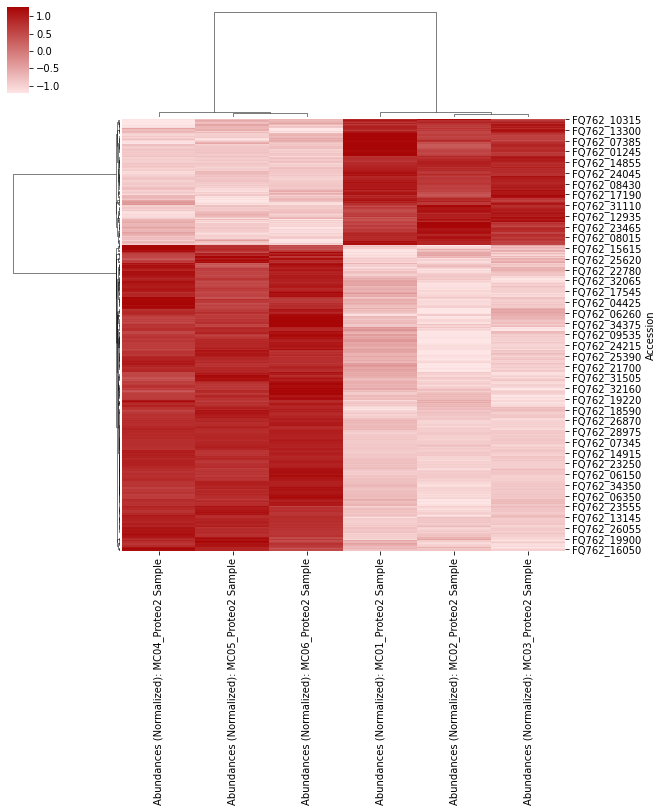

In [88]:
#Clustermap of data where expression is significantly changed
#custom_cmap =sns.light_palette("#A80606",as_cmap=True)
#custom_cmap = sns.diverging_palette(240,0,as_cmap=True, s=99, l=40)
BE9b_ttest = sns.clustermap(core_data_WT_BE9b[core_data_WT_BE9b.index.isin(result_ttest_BE9b[result_ttest_BE9b["pvalue"] < pval].index)],metric='correlation',robust='True',method='average',z_score = 0, cmap="Blues")
BE9b_ttest.savefig(proteomics_dir+sub_dir+data_name+"clustermap_row_norm_T-test_" +str(pval)+"_BE9b_timepoint2"+".svg")
BE9b_ttest

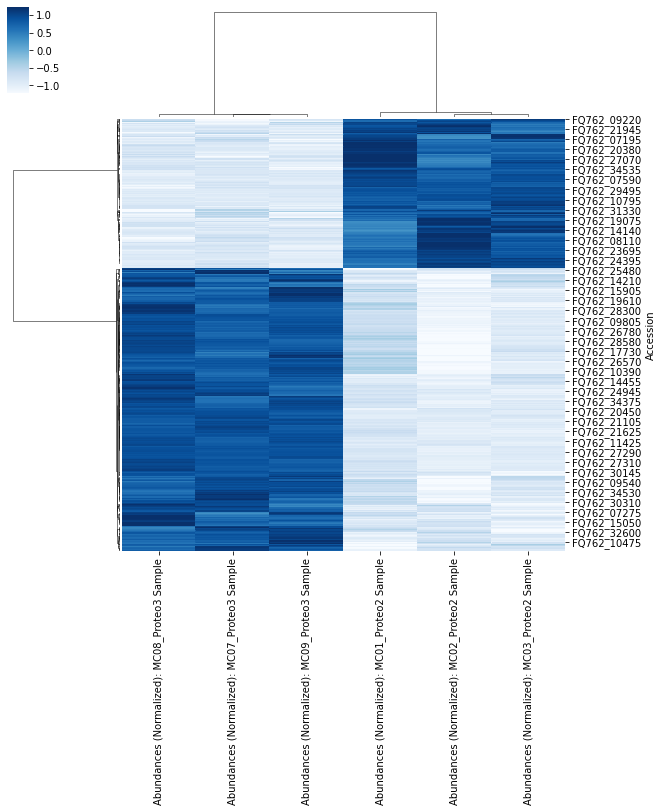

In [21]:
BE18_ttest = sns.clustermap(core_data_WT_BE18[core_data_WT_BE18.index.isin(result_ttest_BE18[result_ttest_BE18["pvalue"] < pval].index)],metric='correlation',robust='True',method='average',z_score = 0, cmap='Blues')
BE18_ttest.savefig(proteomics_dir+sub_dir+data_name+"clustermap_row_norm_T-test_" +str(pval)+"_BE18_timepoint2"+".svg")
BE18_ttest

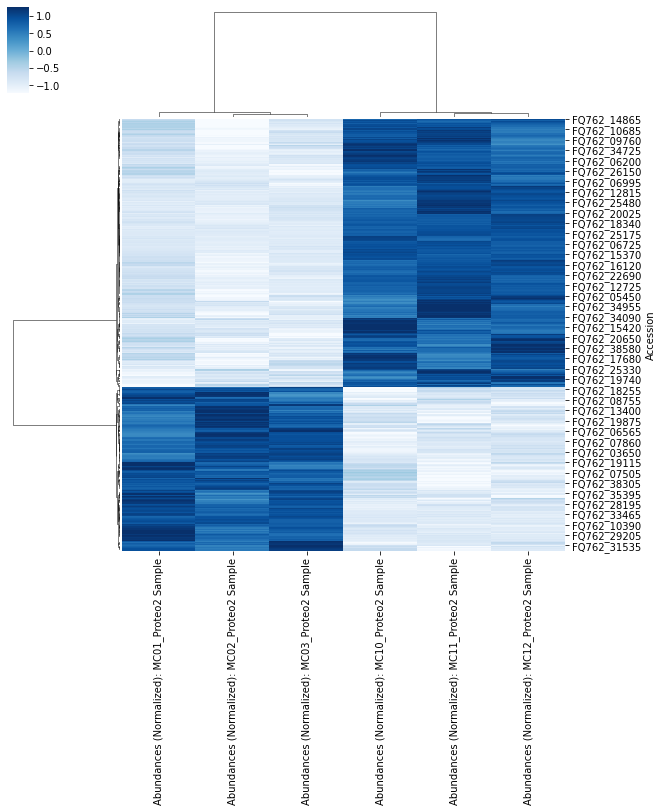

In [22]:
BE28_ttest = sns.clustermap(core_data_WT_BE28[core_data_WT_BE28.index.isin(result_ttest_BE28[result_ttest_BE28["pvalue"] < pval].index)],metric='correlation',robust='True',method='average',z_score = 0, cmap='Blues')
#BE28_ttest.savefig(proteomics_dir+sub_dir+data_name+"clustermap_row_norm_T-test_" + str(pval)+"_BE28_timepoint2"+".svg")
BE28_ttest

### 2.6. COG Annotation of significantly changed locus tags

In [23]:
# Annotate locus tags that are significantly changed with COG Categories

#annotate undetected locus tags with COG categories and descriptions
#list of dataframes with ttest results
df_list=[result_ttest_BE9b,result_ttest_BE18,result_ttest_BE28]

for df in df_list:
    # 1) COG categories
    df["COG_category"] = "-"
    for i in df.index:
        if i in coelicolor_COG.index:
            df["COG_category"].loc[i] =  coelicolor_COG["COG_category"].loc[i]
        else:
            df["COG_category"].loc[i] = "not detected" #not detected means the locus tag is not in the COG annotation

    # 2) COG descriptions
    df["Description"] = "-"
    for i in df["COG_category"].tolist():
        if not i == '-':
            if len(i) == 1: #if len = 1 only one COG category
                df["Description"][df["COG_category"] == i] = COG_categories["Description"].loc[i]
            elif len(i) > 1 and i != "not detected": #if len > 1 more than one COG category
                descript = []
                for l in list(i): #extract all descriptions for the categories
                    descript.append(COG_categories["Description"].loc[l])  
                df["Description"][df["COG_category"] == i] = ','.join(descript)
        else:
            continue

In [44]:
result_ttest_BE9b

,tvalue,pvalue,COG_category,Description
Accession,,,,
FQ762_24085,-1.27417,0.271598,K,Transcription
FQ762_24080,-1.29668,0.264484,K,Transcription
FQ762_27290,-2.37905,0.0760682,C,Energy production and conversion
FQ762_16075,-0.64939,0.551491,C,Energy production and conversion
FQ762_11145,-0.805551,0.465662,C,Energy production and conversion
...,...,...,...,...
FQ762_07600,1.15124,0.313765,K,Transcription
FQ762_09630,-3.17377,0.0337356,K,Transcription
FQ762_06395,0.429344,0.689788,I,Lipid metabolism


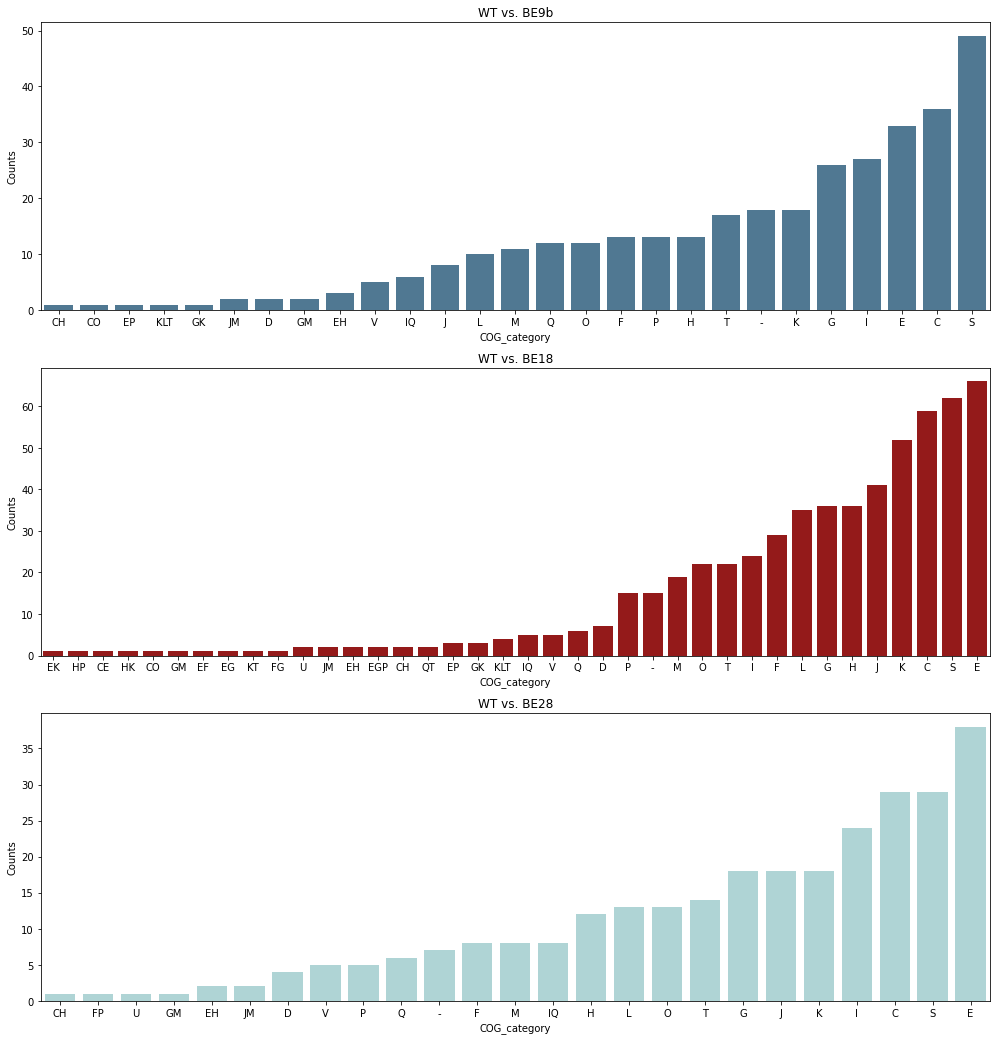

In [98]:
result_ttest_BE9b_counts = result_ttest_BE9b[result_ttest_BE9b["pvalue"] < pval].groupby("COG_category").count().sort_values(by=['Description']).rename(columns={"Description": "Counts"})
result_ttest_BE18_counts = result_ttest_BE18[result_ttest_BE18["pvalue"] < pval].groupby("COG_category").count().sort_values(by=['Description']).rename(columns={"Description": "Counts"})
result_ttest_BE28_counts = result_ttest_BE28[result_ttest_BE28["pvalue"] < pval].groupby("COG_category").count().sort_values(by=['Description']).rename(columns={"Description": "Counts"})

#locus tags that are higher expressed in sample than in control
result_ttest_BE9b_counts_up = result_ttest_BE9b[(result_ttest_BE9b["pvalue"] < pval) & (result_ttest_BE9b["tvalue"] >0)].groupby("COG_category").count().sort_values(by=['Description']).rename(columns={"Description": "Counts"})
result_ttest_BE18_counts_up = result_ttest_BE18[(result_ttest_BE18["pvalue"] < pval) & (result_ttest_BE18["tvalue"] >0)].groupby("COG_category").count().sort_values(by=['Description']).rename(columns={"Description": "Counts"})
result_ttest_BE28_counts_up = result_ttest_BE28[(result_ttest_BE28["pvalue"] < pval) & (result_ttest_BE28["tvalue"] >0)].groupby("COG_category").count().sort_values(by=['Description']).rename(columns={"Description": "Counts"})

#locus tags that are lower expressed in sample than in control
result_ttest_BE9b_counts_down = result_ttest_BE9b[(result_ttest_BE9b["pvalue"] < pval) & (result_ttest_BE9b["tvalue"] < 0)].groupby("COG_category").count().sort_values(by=['Description']).rename(columns={"Description": "Counts"})
result_ttest_BE18_counts_down = result_ttest_BE18[(result_ttest_BE18["pvalue"] < pval) & (result_ttest_BE18["tvalue"] < 0)].groupby("COG_category").count().sort_values(by=['Description']).rename(columns={"Description": "Counts"})
result_ttest_BE28_counts_down = result_ttest_BE28[(result_ttest_BE28["pvalue"] < pval) & (result_ttest_BE28["tvalue"] < 0)].groupby("COG_category").count().sort_values(by=['Description']).rename(columns={"Description": "Counts"})

#result_ttest_BE9b_counts.to_csv(proteomics_dir+sub_dir+data_name+"result_ttest_BE9b_counts_point2_t-test_"+ str(pval)+".csv")
#result_ttest_BE18_counts.to_csv(proteomics_dir+sub_dir+data_name+"result_ttest_BE18_counts_time_point2_t-test_"+ str(pval)+".csv")
#result_ttest_BE28_counts.to_csv(proteomics_dir+sub_dir+data_name+"result_ttest_BE28_counts_time_point2_t-test_"+ str(pval)+".csv")
#result_ttest_BE9b_counts_up.to_csv(proteomics_dir+sub_dir+data_name+"result_ttest_BE9b_counts_up_time_point2_t-test_"+ str(pval)+".csv")
#result_ttest_BE18_counts_up.to_csv(proteomics_dir+sub_dir+data_name+"result_ttest_BE18_counts_up_time_point2_t-test_"+ str(pval)+".csv")
#result_ttest_BE28_counts_up.to_csv(proteomics_dir+sub_dir+data_name+"result_ttest_BE28_counts_up_time_point2_t-test_"+ str(pval)+".csv")
#result_ttest_BE9b_counts_down.to_csv(proteomics_dir+sub_dir+data_name+"result_ttest_BE9b_counts_down_time_point2_t-test_"+ str(pval)+".csv")
#result_ttest_BE18_counts_down.to_csv(proteomics_dir+sub_dir+data_name+"result_ttest_BE18_counts_down_time_point2_t-test_"+ str(pval)+".csv")
#result_ttest_BE28_counts_down.to_csv(proteomics_dir+sub_dir+data_name+"result_ttest_BE28_counts_down_time_point2_t-test_"+ str(pval)+".csv")

#plotting of COG category counts of undetected locus tags
fig, axes = plt.subplots(3,1,figsize=(17,18)) 
axes[0].set_title("WT vs. BE9b")
axes[1].set_title("WT vs. BE18")
axes[2].set_title("WT vs. BE28")
sns.barplot(ax=axes[0],x=result_ttest_BE9b_counts_down.index, y="Counts", data=result_ttest_BE9b_counts_down, color="#457B9D")
sns.barplot(ax=axes[1],x=result_ttest_BE18_counts_down.index, y="Counts", data=result_ttest_BE18_counts_down,color="#A80606")
sns.barplot(ax=axes[2],x=result_ttest_BE28_counts_down.index, y="Counts", data=result_ttest_BE28_counts_down,color="#A8DADC")
#plt.xticks(rotation=90)
plt.show()

In [25]:
result_ttest_BE9b_counts

,tvalue,pvalue,Counts
COG_category,,,
EP,1,1,1
KLT,1,1,1
CE,1,1,1
CH,1,1,1
CO,1,1,1
KO,1,1,1
EG,1,1,1
GK,1,1,1
FG,1,1,1


In [43]:
#check for overlaps between significant locus tags
BE9b_BE18_ttest_shared = []
BE9b_BE28_ttest_shared = []
BE18_BE28_ttest_shared = []
BE9b_BE18_BE28_ttest_shared = []

for i in result_ttest_BE28[result_ttest_BE28["pvalue"] < pval].index:
    if any(i in s for s in result_ttest_BE18[result_ttest_BE18["pvalue"] < pval].index):
        BE18_BE28_ttest_shared.append(i)
    if any(i in s for s in result_ttest_BE9b[result_ttest_BE9b["pvalue"] < pval].index):
        BE9b_BE28_ttest_shared.append(i)
for i in result_ttest_BE9b[result_ttest_BE9b["pvalue"] < pval].index:
    if any(i in s for s in result_ttest_BE18[result_ttest_BE18["pvalue"] < pval].index):
        BE9b_BE18_ttest_shared.append(i)
for i in BE9b_BE18_ttest_shared:
    if any(i in s for s in BE9b_BE28_ttest_shared) and any(i in l for l in BE18_BE28_ttest_shared):
        BE9b_BE18_BE28_ttest_shared.append(i)

print(len(result_ttest_BE9b[result_ttest_BE9b["pvalue"] < pval].index),len(result_ttest_BE18[result_ttest_BE18["pvalue"] < pval].index),len(result_ttest_BE28[result_ttest_BE28["pvalue"] < pval].index))
print(len(BE9b_BE18_ttest_shared), len(BE9b_BE28_ttest_shared), len(BE18_BE28_ttest_shared))


#venn2([result_ttest_BE9b[result_ttest_BE9b["pvalue"] < pval && ].index[,set(BE9b_BE28_ttest_shared),set(BE18_BE28_ttest_shared)], set_labels=("BE9b ","BE18","BE28"))

#print(set(result_ttest_BE9b[result_ttest_BE9b["pvalue"] < pval].index) & set(result_ttest_BE18[result_ttest_BE18["pvalue"] < pval].index) & set(result_ttest_BE28[result_ttest_BE28["pvalue"] < pval].index))
print(BE9b_BE18_ttest_shared)
print(len(BE9b_BE18_BE28_ttest_shared), len(set(BE9b_BE18_BE28_ttest_shared)))

482 900 457
292 225 315
['FQ762_30015', 'FQ762_27005', 'FQ762_34365', 'FQ762_18790', 'FQ762_26415', 'FQ762_20450', 'FQ762_28290', 'FQ762_34370', 'FQ762_11130', 'FQ762_18850', 'FQ762_09860', 'FQ762_34375', 'FQ762_09920', 'FQ762_26065', 'FQ762_16125', 'FQ762_13500', 'FQ762_10620', 'FQ762_22900', 'FQ762_03370', 'FQ762_30190', 'FQ762_10210', 'FQ762_08435', 'FQ762_22220', 'FQ762_19515', 'FQ762_29340', 'FQ762_09910', 'FQ762_11135', 'FQ762_38755', 'FQ762_13040', 'FQ762_36310', 'FQ762_34350', 'FQ762_09800', 'FQ762_09790', 'FQ762_20975', 'FQ762_12635', 'FQ762_28505', 'FQ762_34360', 'FQ762_20130', 'FQ762_24945', 'FQ762_19985', 'FQ762_28265', 'FQ762_11370', 'FQ762_17190', 'FQ762_11280', 'FQ762_12935', 'FQ762_20320', 'FQ762_14820', 'FQ762_19635', 'FQ762_26055', 'FQ762_14915', 'FQ762_22000', 'FQ762_20050', 'FQ762_28255', 'FQ762_39465', 'FQ762_24620', 'FQ762_08360', 'FQ762_17030', 'FQ762_20035', 'FQ762_11385', 'FQ762_09785', 'FQ762_09695', 'FQ762_38730', 'FQ762_19645', 'FQ762_19670', 'FQ762_21095', 

In [51]:
ttests_shared = pd.concat([result_ttest_BE9b, result_ttest_BE18, result_ttest_BE28],axis=1)
ttests_shared[ttests_shared.index.isin(BE9b_BE18_BE28_ttest_shared)]
#ttests_shared[ttests_shared.index.isin(BE9b_BE18_BE28_ttest_shared)].to_csv(proteomics_dir+sub_dir+data_name+"ttests_shared_significant_change_t2_t-test_"+ str(pval)+".csv")
#sns.barplot(x=result_ttest_BE9b_counts_down.index, y="Counts", data=result_ttest_BE9b_counts_down)
ttests_shared[ttests_shared.index.isin(BE9b_BE18_BE28_ttest_shared)] #.groupby("COG_category").count().sort_values(by=['Description']).rename(columns={"Description": "Counts"})


,tvalue,pvalue,COG_category,Description,tvalue,pvalue,COG_category,Description,tvalue,pvalue,COG_category,Description
Accession,,,,,,,,,,,,
FQ762_30015,-12.5495,0.000231994,F,Nucleotide metabolism and transport,-10.9538,0.000394577,F,Nucleotide metabolism and transport,-11.1673,0.000366014,F,Nucleotide metabolism and transport
FQ762_27005,-16.5966,7.72031e-05,F,Nucleotide metabolism and transport,-25.7974,1.34124e-05,F,Nucleotide metabolism and transport,-14.6407,0.000126622,F,Nucleotide metabolism and transport
FQ762_34365,-20.4325,3.38813e-05,G,Carbohydrate metabolism and transport,-28.1072,9.53295e-06,G,Carbohydrate metabolism and transport,-34.8695,4.03637e-06,G,Carbohydrate metabolism and transport
FQ762_20450,-9.05532,0.000824191,E,Amino Acid metabolis and transport,-38.6562,2.6751e-06,E,Amino Acid metabolis and transport,-15.1211,0.000111497,E,Amino Acid metabolis and transport
FQ762_34370,-7.23445,0.00193704,G,Carbohydrate metabolism and transport,-13.4986,0.000174288,G,Carbohydrate metabolism and transport,-15.7507,9.4923e-05,G,Carbohydrate metabolism and transport
...,...,...,...,...,...,...,...,...,...,...,...,...
FQ762_09395,-10.1879,0.000522898,S,Function Unknown,-8.30954,0.0011456,S,Function Unknown,-8.42003,0.00108924,S,Function Unknown
FQ762_22315,-18.7021,4.81233e-05,L,Replication and repair,-24.3138,1.6977e-05,L,Replication and repair,-12.3188,0.000249481,L,Replication and repair
FQ762_32135,6.99303,0.00220033,E,Amino Acid metabolis and transport,6.11202,0.00362767,E,Amino Acid metabolis and transport,6.11375,0.00362388,E,Amino Acid metabolis and transport


In [157]:
##Extra: Check if significantly changed locus tags were edited
BE28_SNPs = pd.read_csv("cwi100_strict_results.csv",sep=";")
BE28_SNPs["gene"].replace('→','', regex=True, inplace=True)
BE28_SNPs["gene"].replace('←','', regex=True, inplace=True)

BE18_SNPs = pd.read_csv("cwi99_strict_results.csv",sep=";")
BE18_SNPs["gene"].replace('→','', regex=True, inplace=True)
BE18_SNPs["gene"].replace('←','', regex=True, inplace=True)

BE9b_SNPs = pd.read_csv("cwi98_strict_results.csv",sep=";")
BE9b_SNPs["gene"].replace('→','', regex=True, inplace=True)
BE9b_SNPs["gene"].replace('←','', regex=True, inplace=True)

proteome_BE28_edited = []
proteome_BE18_edited = []
proteome_BE9b_edited = []

for i in result_ttest_BE28[result_ttest_BE28["pvalue"] < pval].index:
    if any(i in s for s in BE28_SNPs["gene"].to_list()):
        proteome_BE28_edited.append(i)

for i in result_ttest_BE18[result_ttest_BE18["pvalue"] < pval].index:
    if any(i in s for s in BE18_SNPs["gene"].to_list()):
        proteome_BE18_edited.append(i)
        
for i in result_ttest_BE9b[result_ttest_BE9b["pvalue"] < pval].index:
    if any(i in s for s in BE9b_SNPs["gene"].to_list()):
        proteome_BE9b_edited.append(i)

print("BE9b:Out of " , len(result_ttest_BE9b[result_ttest_BE9b["pvalue"] < pval].index), "significantly changed locus tags, " , len(proteome_BE9b_edited), "have SNPs in or around the CDS.")
print("BE18:Out of " , len(result_ttest_BE18[result_ttest_BE18["pvalue"] < pval].index), "significantly changed locus tags, " , len(proteome_BE18_edited), "have SNPs in or around the CDS.")
print("BE28:Out of " , len(result_ttest_BE28[result_ttest_BE28["pvalue"] < pval].index), "significantly changed locus tags, " , len(proteome_BE28_edited), "have SNPs in or around the CDS.")

BE9b:Out of  482 significantly changed locus tags,  3 have SNPs in or around the CDS.
BE18:Out of  900 significantly changed locus tags,  1 have SNPs in or around the CDS.
BE28:Out of  457 significantly changed locus tags,  2 have SNPs in or around the CDS.


In [119]:
core_data_WT_BE9b.iloc[: , :6]

,Abundances (Normalized): MC01_Proteo2 Sample,Abundances (Normalized): MC02_Proteo2 Sample,Abundances (Normalized): MC03_Proteo2 Sample,Abundances (Normalized): MC04_Proteo2 Sample,Abundances (Normalized): MC05_Proteo2 Sample,Abundances (Normalized): MC06_Proteo2 Sample
Accession,,,,,,
FQ762_24085,8.846772e+08,7.813055e+08,8.332682e+08,8.532477e+08,8.696870e+08,9.037809e+08
FQ762_24080,7.451347e+08,6.614162e+08,6.943140e+08,7.134240e+08,7.314466e+08,7.728698e+08
FQ762_27290,6.497865e+08,5.853108e+08,6.147268e+08,6.472840e+08,6.723428e+08,6.844034e+08
FQ762_16075,7.216484e+08,6.418126e+08,7.056409e+08,6.821330e+08,7.251131e+08,7.157364e+08
FQ762_11145,3.558141e+08,3.237328e+08,3.402384e+08,3.383388e+08,3.583782e+08,3.494747e+08
...,...,...,...,...,...,...
FQ762_07600,3.521366e+06,9.081316e+06,6.395035e+06,4.218836e+06,4.506184e+06,4.706812e+06
FQ762_09630,5.075202e+06,5.741530e+06,4.722125e+06,6.664806e+06,8.936869e+06,7.126178e+06
FQ762_06395,8.580000e+05,5.779918e+05,6.084867e+05,4.915512e+05,6.014825e+05,7.910082e+05


In [132]:
#try to plot volcano plot, Log2(Avg(cases)/Avg(controls)) on x axis,  -log10 of the P-value.
volcano_BE9b = result_ttest_BE9b
volcano_BE9b["-log10 Pvalue"] = np.log10(volcano_BE9b["pvalue"].astype('float64'))
volcano_BE9b["-log10 Pvalue"] *= -1
volcano_BE9b["fold change"] = np.log2(core_data_WT_BE9b[core_data_WT_BE9b.index.isin(volcano_BE9b.index)].iloc[: , 3:6].mean(axis=1)/core_data_WT_BE9b[core_data_WT_BE9b.index.isin(volcano_BE9b.index)].iloc[: , :3].mean(axis=1))

volcano_BE18 = result_ttest_BE18
volcano_BE18["-log10 Pvalue"] = np.log10(volcano_BE18["pvalue"].astype('float64'))
volcano_BE18["fold change"] = np.log2(core_data_WT_BE18[core_data_WT_BE18.index.isin(volcano_BE18.index)].iloc[: , 3:6].mean(axis=1)/core_data_WT_BE18[core_data_WT_BE18.index.isin(volcano_BE18.index)].iloc[: , :3].mean(axis=1))
volcano_BE18["-log10 Pvalue"] *= -1

volcano_BE28 = result_ttest_BE28
volcano_BE28["-log10 Pvalue"] = np.log10(volcano_BE28["pvalue"].astype('float64'))
volcano_BE28["fold change"] = np.log2(core_data_WT_BE28[core_data_WT_BE28.index.isin(volcano_BE28.index)].iloc[: , 3:6].mean(axis=1)/core_data_WT_BE28[core_data_WT_BE28.index.isin(volcano_BE28.index)].iloc[: , :3].mean(axis=1))
volcano_BE28["-log10 Pvalue"] *= -1

volcano_BE9b.to_csv(proteomics_dir+sub_dir+data_name+"volcano_data_BE9b_time_point2_t-test_"+ str(pval)+".csv")
volcano_BE18.to_csv(proteomics_dir+sub_dir+data_name+"volcano_data_BE18_time_point2_t-test_"+ str(pval)+".csv")
volcano_BE28.to_csv(proteomics_dir+sub_dir+data_name+"volcano_data_BE28_time_point2_t-test_"+ str(pval)+".csv")

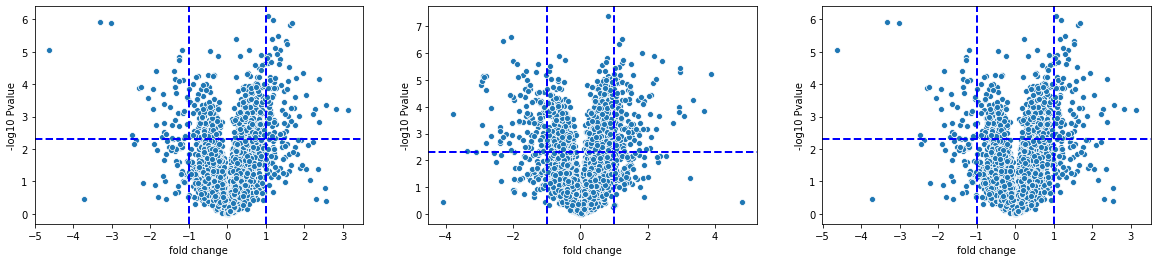

In [141]:
fig, axes = plt.subplots(1,3, figsize=(20,4))

#sns.scatterplot(ax=axes[0],x=volcano_BE9b["fold change"][(volcano_BE9b["fold change"]<(-np.log2(2))) |(volcano_BE9b["fold change"]>(np.log2(2)))] , y=volcano_BE9b["-log10 Pvalue"][(volcano_BE9b["-log10 Pvalue"]>(-np.log10(pval)))], data=volcano_BE9b, color="red")
sns.scatterplot(ax=axes[0],x="fold change", y="-log10 Pvalue", data=volcano_BE28)
axes[0].axhline((-np.log10(pval)), color='blue', ls='--', lw=2)
axes[0].axvline((-np.log2(2)), color='blue', ls='--', lw=2)
axes[0].axvline((np.log2(2)), color='blue', ls='--', lw=2)

sns.scatterplot(ax=axes[1],x="fold change", y="-log10 Pvalue", data=volcano_BE18)
axes[1].axhline((-np.log10(pval)), color='blue', ls='--', lw=2)
axes[1].axvline((-np.log2(2)), color='blue', ls='--', lw=2)
axes[1].axvline((np.log2(2)), color='blue', ls='--', lw=2)

sns.scatterplot(ax=axes[2],x="fold change", y="-log10 Pvalue", data=volcano_BE28)
axes[2].axhline((-np.log10(pval)), color='blue', ls='--', lw=2)
axes[2].axvline((-np.log2(2)), color='blue', ls='--', lw=2)
axes[2].axvline((np.log2(2)), color='blue', ls='--', lw=2)

plt.show()

In [153]:
volcano_BE9b_up = volcano_BE9b[((volcano_BE9b["fold change"]>1))&(volcano_BE9b["-log10 Pvalue"]>(-np.log10(pval)))]
volcano_BE9b_down = volcano_BE9b[((volcano_BE9b["fold change"]<-1))&(volcano_BE9b["-log10 Pvalue"]>(-np.log10(pval)))]

volcano_BE9b_up.to_csv(proteomics_dir+sub_dir+data_name+"volcano_data_BE9b_fold_up_time_point2_t-test_"+ str(pval)+".csv")
volcano_BE9b_down.to_csv(proteomics_dir+sub_dir+data_name+"volcano_data_BE9b_fold_down_time_point2_t-test_"+ str(pval)+".csv")
volcano_BE9b_up.groupby("COG_category").count().sort_values(by=['Description']).rename(columns={"Description": "Counts"}).to_csv(proteomics_dir+sub_dir+data_name+"volcano_data_BE9b_fold_up_counts_time_point2_t-test_"+ str(pval)+".csv")
volcano_BE9b_down.groupby("COG_category").count().sort_values(by=['Description']).rename(columns={"Description": "Counts"}).to_csv(proteomics_dir+sub_dir+data_name+"volcano_data_BE9b_fold_down_counts_time_point2_t-test_"+ str(pval)+".csv")

volcano_BE18_up = volcano_BE18[((volcano_BE18["fold change"]>1))&(volcano_BE18["-log10 Pvalue"]>(-np.log10(pval)))]
volcano_BE18_down = volcano_BE18[((volcano_BE18["fold change"]<-1))&(volcano_BE18["-log10 Pvalue"]>(-np.log10(pval)))]

volcano_BE18_up.to_csv(proteomics_dir+sub_dir+data_name+"volcano_data_BE18_fold_up_time_point2_t-test_"+ str(pval)+".csv")
volcano_BE18_down.to_csv(proteomics_dir+sub_dir+data_name+"volcano_data_BE18_fold_down_time_point2_t-test_"+ str(pval)+".csv")
volcano_BE18_up.groupby("COG_category").count().sort_values(by=['Description']).rename(columns={"Description": "Counts"}).to_csv(proteomics_dir+sub_dir+data_name+"volcano_data_BE18_fold_up_counts_time_point2_t-test_"+ str(pval)+".csv")
volcano_BE18_down.groupby("COG_category").count().sort_values(by=['Description']).rename(columns={"Description": "Counts"}).to_csv(proteomics_dir+sub_dir+data_name+"volcano_data_BE18_fold_down_counts_time_point2_t-test_"+ str(pval)+".csv")

volcano_BE28_up = volcano_BE28[((volcano_BE28["fold change"]>1))&(volcano_BE28["-log10 Pvalue"]>(-np.log10(pval)))]
volcano_BE28_down = volcano_BE28[((volcano_BE28["fold change"]<-1))&(volcano_BE28["-log10 Pvalue"]>(-np.log10(pval)))]

volcano_BE28_up.to_csv(proteomics_dir+sub_dir+data_name+"volcano_data_BE28_fold_up_time_point2_t-test_"+ str(pval)+".csv")
volcano_BE28_down.to_csv(proteomics_dir+sub_dir+data_name+"volcano_data_BE28_fold_down_time_point2_t-test_"+ str(pval)+".csv")
volcano_BE28_up.groupby("COG_category").count().sort_values(by=['Description']).rename(columns={"Description": "Counts"}).to_csv(proteomics_dir+sub_dir+data_name+"volcano_data_BE28_fold_up_counts_time_point2_t-test_"+ str(pval)+".csv")
volcano_BE28_down.groupby("COG_category").count().sort_values(by=['Description']).rename(columns={"Description": "Counts"}).to_csv(proteomics_dir+sub_dir+data_name+"volcano_data_BE28_fold_down_counts_time_point2_t-test_"+ str(pval)+".csv")

In [37]:
##NEW SNP Matching based on transcriptomics approach
BE9b_SNPs = pd.read_csv("/Users/chrwhi/Documents/PhD/Lab/MCBE/NGS_Data/cwi98-strict/cwi98_strict_results_no_intergenic_no_genenames.csv")
BE18_SNPs = pd.read_csv("/Users/chrwhi/Documents/PhD/Lab/MCBE/NGS_Data/cwi99-strict/cwi99_strict_results_no_intergenic_no_genenames.csv")
BE28_SNPs = pd.read_csv("/Users/chrwhi/Documents/PhD/Lab/MCBE/NGS_Data/cwi100-strict/cwi100_strict_results_no_intergenic_no_genenames.csv")

volcano_BE9b = pd.read_csv("/Users/chrwhi/Documents/PhD/Lab/MCBE/OMICS_Data/Proteomics/Analysis_BE/MCBE_BE_datavolcano_data_BE9b_time_point2_t-test_0.005.csv").set_index("Accession")
volcano_BE18 = pd.read_csv("/Users/chrwhi/Documents/PhD/Lab/MCBE/OMICS_Data/Proteomics/Analysis_BE/MCBE_BE_datavolcano_data_BE18_time_point2_t-test_0.005.csv").set_index("Accession")
volcano_BE28 = pd.read_csv("/Users/chrwhi/Documents/PhD/Lab/MCBE/OMICS_Data/Proteomics/Analysis_BE/MCBE_BE_datavolcano_data_BE28_time_point2_t-test_0.005.csv").set_index("Accession")

##matching on locustags
#data for all targeted locustags

locus_tags = ("FQ762_00575","FQ762_00875","FQ762_01290","FQ762_02415","FQ762_03740","FQ762_06065","FQ762_09505","FQ762_13840","FQ762_14260","FQ762_16595","FQ762_26280","FQ762_26985","FQ762_27465","FQ762_29990","FQ762_30470","FQ762_31255","FQ762_31390","FQ762_32170","FQ762_32415","FQ762_33215","FQ762_34460","FQ762_34870","FQ762_35220","FQ762_35750","FQ762_37095","FQ762_38505","FQ762_39600","FQ762_37265")

BE9b_WT_locustags = volcano_BE9b[volcano_BE9b.index.isin(locus_tags)]
BE18_WT_locustags = volcano_BE18[volcano_BE18.index.isin(locus_tags)]
BE28_WT_locustags = volcano_BE28[volcano_BE28.index.isin(locus_tags)]


BE9b_SNPs["gene"] = BE9b_SNPs["gene"].str.strip()
BE9b_SNPs_reindex = BE9b_SNPs.set_index("gene")
BE9b_WT_locustags_SNPs = BE9b_WT_locustags.merge(BE9b_SNPs_reindex["annotation"], how='left', left_index=True, right_index=True)

BE18_SNPs["gene"] = BE18_SNPs["gene"].str.strip()
BE18_SNPs_reindex = BE18_SNPs.set_index("gene")
BE18_WT_locustags_SNPs = BE18_WT_locustags.merge(BE18_SNPs_reindex["annotation"], how='left', left_index=True, right_index=True)

BE28_SNPs["gene"] = BE28_SNPs["gene"].str.strip()
BE28_SNPs_reindex = BE28_SNPs.set_index("gene")
BE28_WT_locustags_SNPs = BE28_WT_locustags.merge(BE28_SNPs_reindex["annotation"], how='left', left_index=True, right_index=True)

#BE9b_WT_locustags_SNPs.to_csv("/Users/chrwhi/Documents/PhD/Lab/MCBE/OMICS_Data/Proteomics/Analysis_BE/20220902_BE9b_Proteomics_targeted_genes.csv")
#BE18_WT_locustags_SNPs.to_csv("/Users/chrwhi/Documents/PhD/Lab/MCBE/OMICS_Data/Proteomics/Analysis_BE/20220902_BE18_Proteomics_targeted_genes.csv")
#BE28_WT_locustags_SNPs.to_csv("/Users/chrwhi/Documents/PhD/Lab/MCBE/OMICS_Data/Proteomics/Analysis_BE/20220902_BE28_Proteomics_targeted_genes.csv")



In [46]:
BE9b_WT_counts_up_new["-log10 Pvalue"].max()

6.901915673504474

In [45]:
#Map to SNPs
#Here, fold change is already the log2, so use 1 instead of 2! 
BE9b_WT_counts_up_new = volcano_BE9b[(volcano_BE9b["pvalue"] < 0.005) & (volcano_BE9b["fold change"] >1)]
BE9b_WT_counts_down_new = volcano_BE9b[(volcano_BE9b["pvalue"] < 0.005) & (volcano_BE9b["fold change"] <(-1))]

BE18_WT_counts_up_new = volcano_BE18[(volcano_BE18["pvalue"] < 0.005) & (volcano_BE18["fold change"] >1)]
BE18_WT_counts_down_new = volcano_BE18[(volcano_BE18["pvalue"] < 0.005) & (volcano_BE18["fold change"] <(-1))]

BE28_WT_counts_up_new = volcano_BE28[(volcano_BE28["pvalue"] < 0.005) & (volcano_BE28["fold change"] >1)]
BE28_WT_counts_down_new = volcano_BE28[(volcano_BE28["pvalue"] < 0.005) & (volcano_BE28["fold change"] <(-1))]

proteome_BE28_edited_up = []
proteome_BE18_edited_up = []
proteome_BE9b_edited_up = []

proteome_BE28_edited_down = []
proteome_BE18_edited_down = []
proteome_BE9b_edited_down = []

for i in BE28_WT_counts_up_new.index:
    if any(i in s for s in BE28_SNPs["gene"].to_list()):
        proteome_BE28_edited_up.append(i)

for i in BE18_WT_counts_up_new.index:
    if any(i in s for s in BE18_SNPs["gene"].to_list()):
        proteome_BE18_edited_up.append(i)
        
for i in BE9b_WT_counts_up_new.index:
    if any(i in s for s in BE9b_SNPs["gene"].to_list()):
        proteome_BE9b_edited_up.append(i)
        
for i in BE28_WT_counts_down_new.index:
    if any(i in s for s in BE28_SNPs["gene"].to_list()):
        proteome_BE28_edited_down.append(i)

for i in BE18_WT_counts_down_new.index:
    if any(i in s for s in BE18_SNPs["gene"].to_list()):
        proteome_BE18_edited_down.append(i)
        
for i in BE9b_WT_counts_down_new.index:
    if any(i in s for s in BE9b_SNPs["gene"].to_list()):
        proteome_BE9b_edited_down.append(i)
        

print("Up:")
print("BE9b:Out of " , len(BE9b_WT_counts_up_new.index), "significantly changed locus tags, " , len(proteome_BE9b_edited_up), "have SNPs in or around the CDS.")
print("BE18:Out of " , len(BE18_WT_counts_up_new.index), "significantly changed locus tags, " , len(proteome_BE18_edited_up), "have SNPs in or around the CDS.")
print("BE28:Out of " , len(BE28_WT_counts_up_new.index), "significantly changed locus tags, " , len(proteome_BE28_edited_up), "have SNPs in or around the CDS.")

print("Down:")
print("BE9b:Out of " , len(BE9b_WT_counts_down_new.index), "significantly changed locus tags, " , len(proteome_BE9b_edited_down), "have SNPs in or around the CDS.")
print("BE18:Out of " , len(BE18_WT_counts_down_new.index), "significantly changed locus tags, " , len(proteome_BE18_edited_down), "have SNPs in or around the CDS.")
print("BE28:Out of " , len(BE28_WT_counts_down_new.index), "significantly changed locus tags, " , len(proteome_BE28_edited_down), "have SNPs in or around the CDS.")

#save matched locustags 



Up:
BE9b:Out of  122 significantly changed locus tags,  2 have SNPs in or around the CDS.
BE18:Out of  136 significantly changed locus tags,  1 have SNPs in or around the CDS.
BE28:Out of  83 significantly changed locus tags,  3 have SNPs in or around the CDS.
Down:
BE9b:Out of  29 significantly changed locus tags,  0 have SNPs in or around the CDS.
BE18:Out of  105 significantly changed locus tags,  3 have SNPs in or around the CDS.
BE28:Out of  44 significantly changed locus tags,  4 have SNPs in or around the CDS.


In [182]:
for i in BE18_SNPs["gene"].to_list():
    if not i in BE9b_SNPs["gene"].to_list():
        if not i in BE28_SNPs["gene"].to_list():
            print(i)

FQ762_00335  /  FQ762_00340
FQ762_00475 
FQ762_00555 
narH 
FQ762_01390 
FQ762_01470 
FQ762_01520 
FQ762_03140 
FQ762_03150 
FQ762_03450 
FQ762_03940 
FQ762_05270  /  FQ762_05275
FQ762_06290 
FQ762_06325 
FQ762_06325 
FQ762_06520 
FQ762_07020 
FQ762_07630 
FQ762_07775 
FQ762_08090 
FQ762_08595 
FQ762_08880 
FQ762_10065 
FQ762_10355 
FQ762_10875 
efeB 
FQ762_12310 
FQ762_12615  /  FQ762_12620
FQ762_12720 
nirB 
FQ762_12780 
FQ762_12910 
FQ762_13455 
pepN 
FQ762_13715 
FQ762_13755 
FQ762_13995 
FQ762_14055  /  FQ762_14060
FQ762_14265 
FQ762_15500 
FQ762_15505 
FQ762_16365 
FQ762_16600 
FQ762_17350 
FQ762_18605  /  FQ762_18610
FQ762_19795 
FQ762_19925  /  FQ762_19930
FQ762_20285 
FQ762_21580 
FQ762_21915 
ugpC  /  FQ762_21935
FQ762_23150  /  FQ762_23155
nusG  /  rplK
FQ762_24070  /  FQ762_24075
rpoB 
FQ762_24750 
FQ762_24775 
FQ762_25170 
FQ762_26045 
FQ762_26370 
FQ762_26565  /  FQ762_26570
FQ762_27010  /  FQ762_27015
FQ762_27060  /  FQ762_27065
FQ762_28580 
FQ762_28605 
FQ762_28795 
FQ7

Dataframe CP042324.1.region019 is empty!
Dataframe CP042324.1.region005 is empty!


/Users/chrwhi/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Dataframe BE9b is empty!


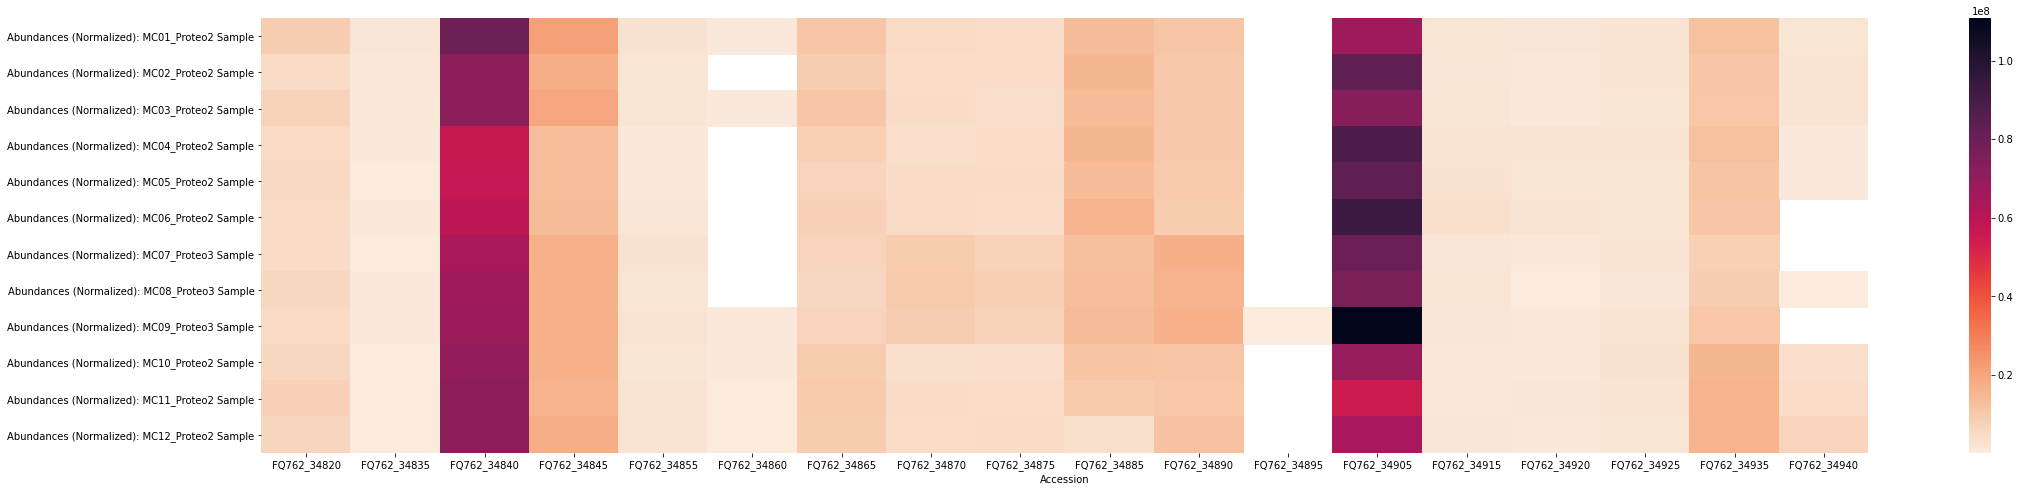

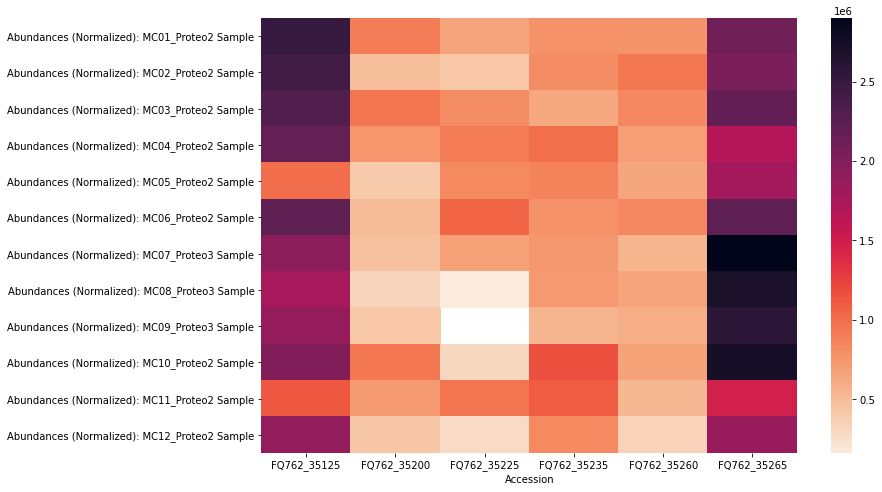

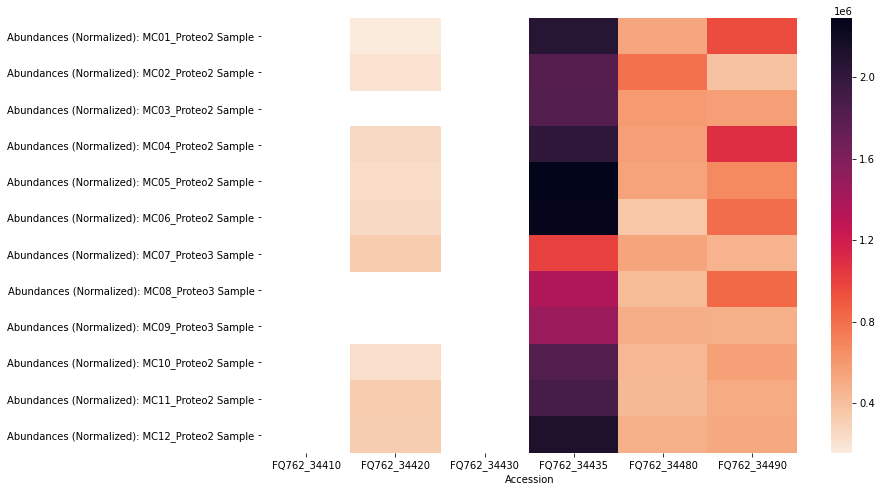

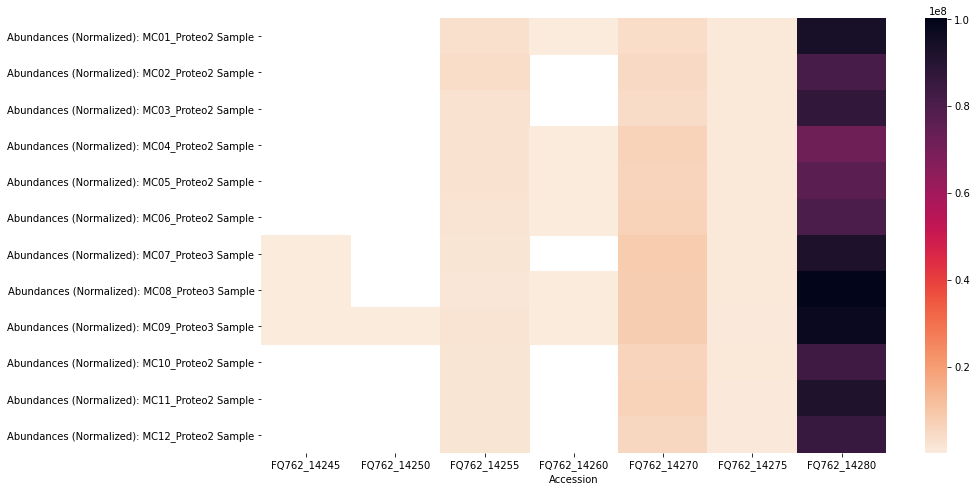

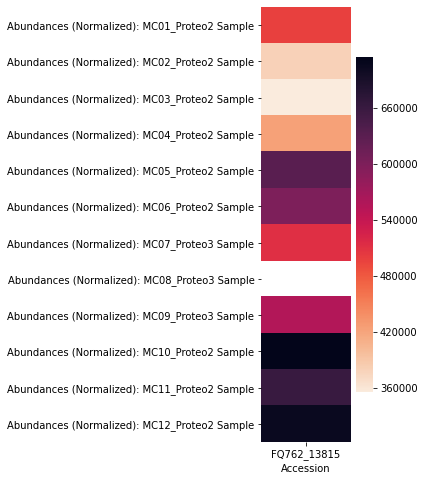

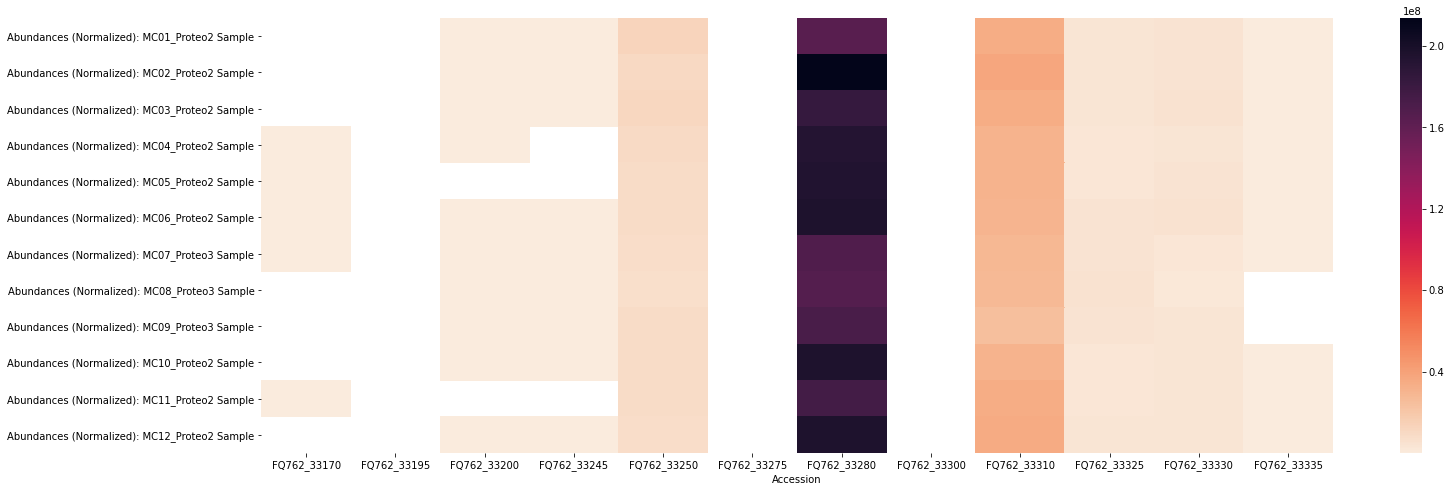

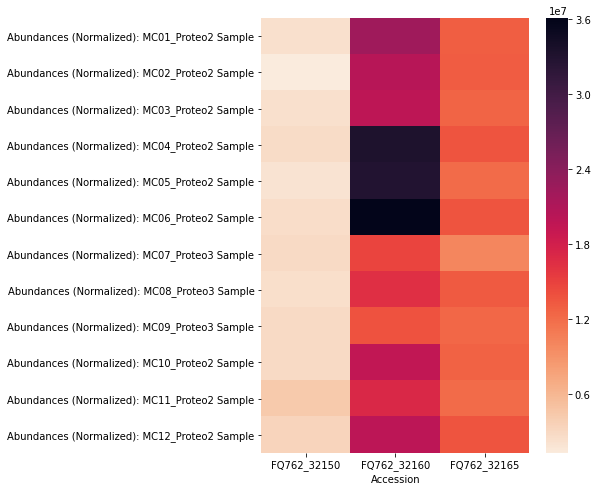

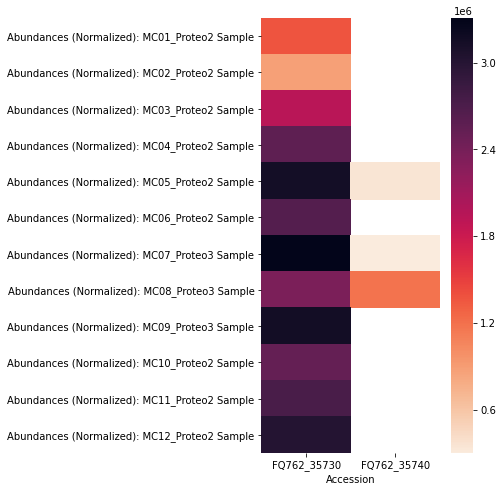

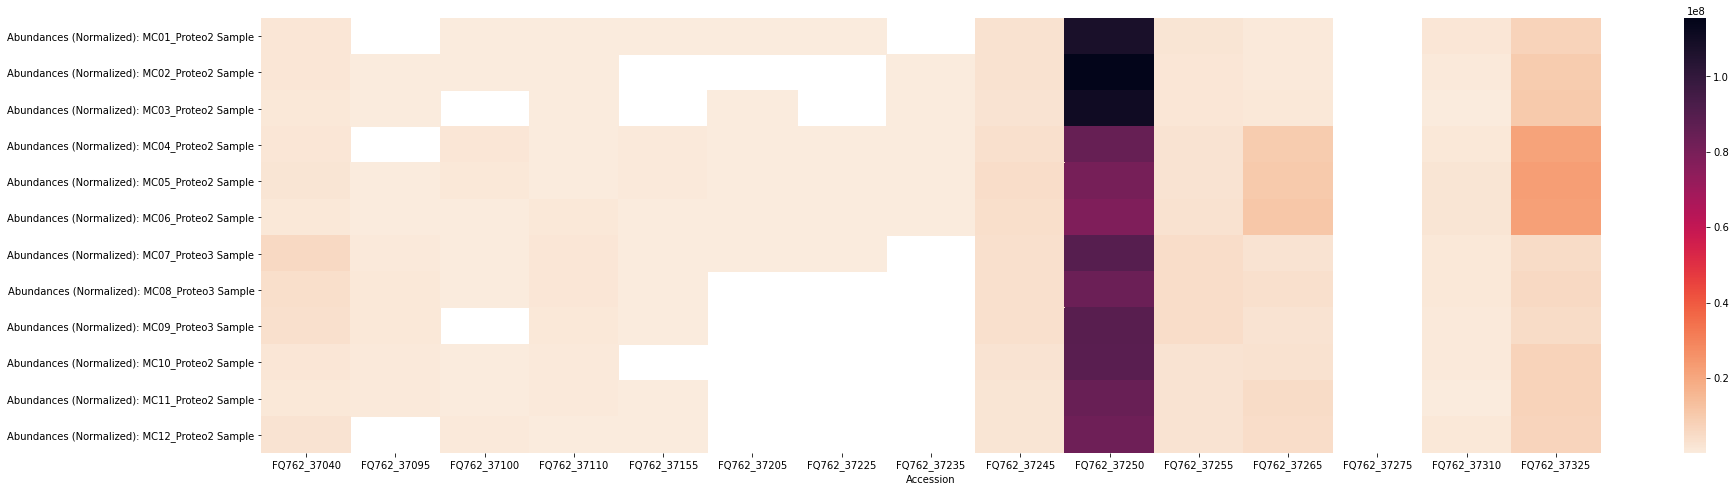

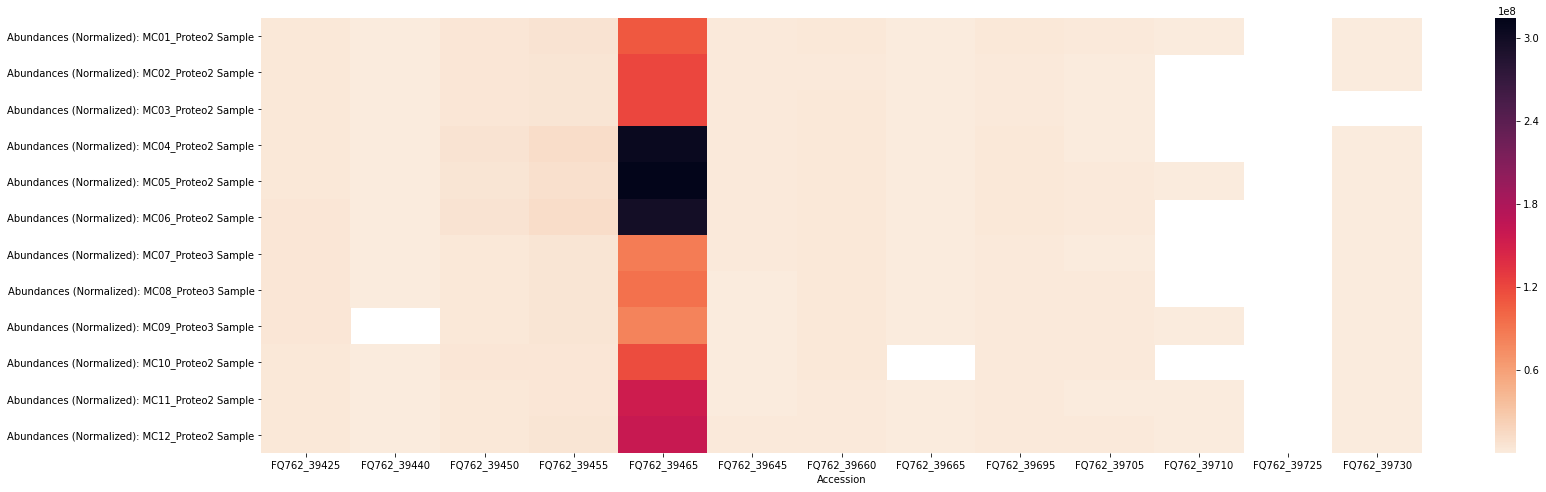

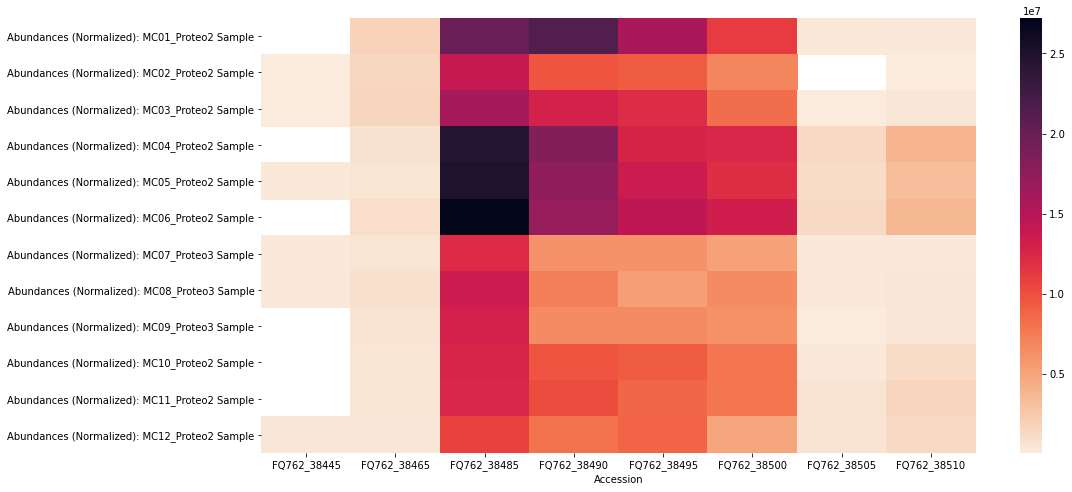

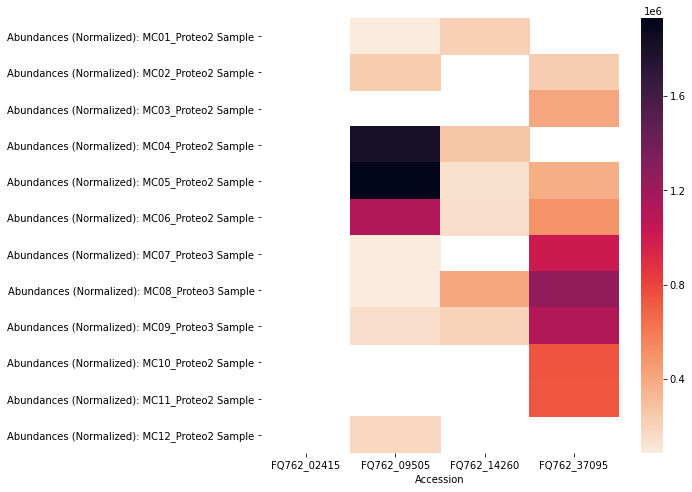

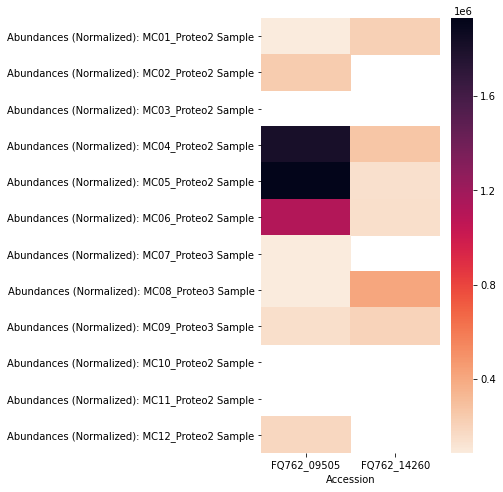

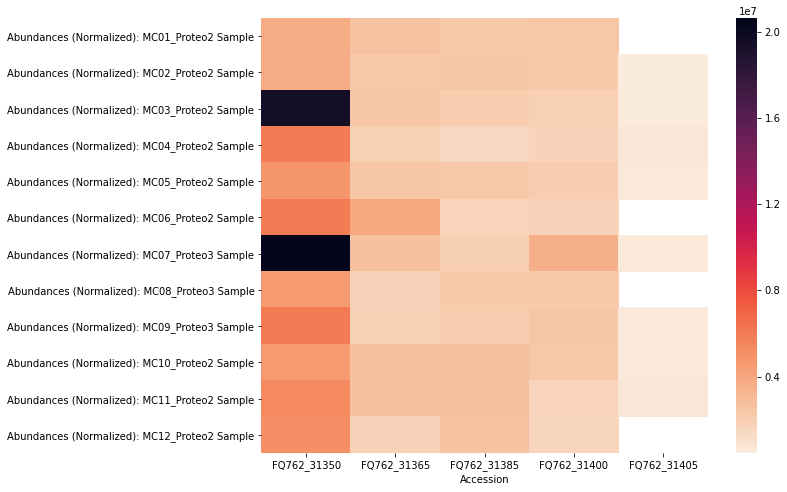

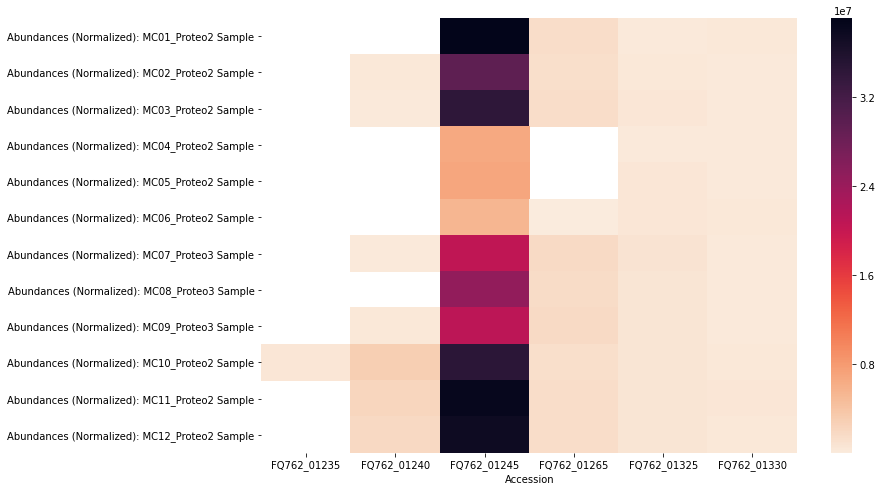

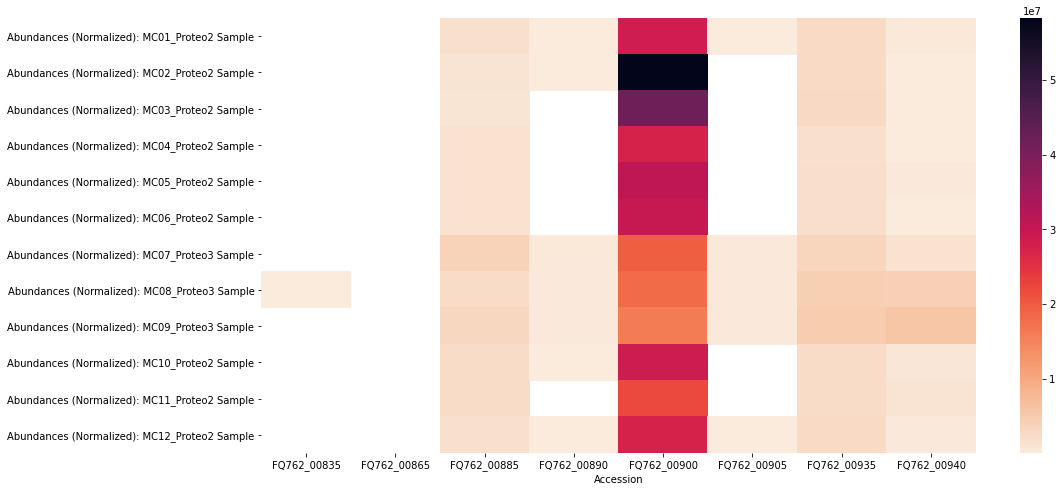

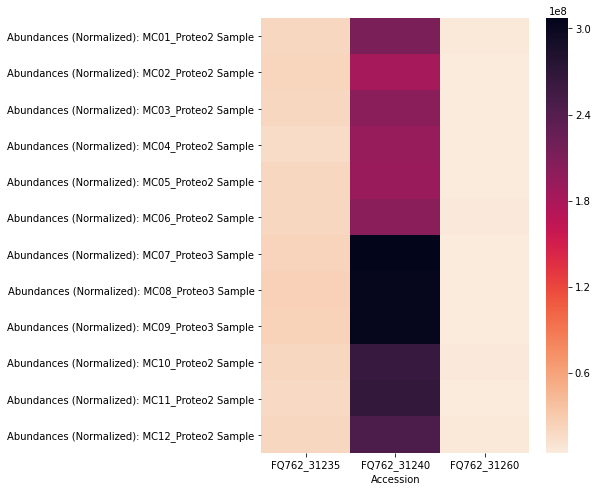

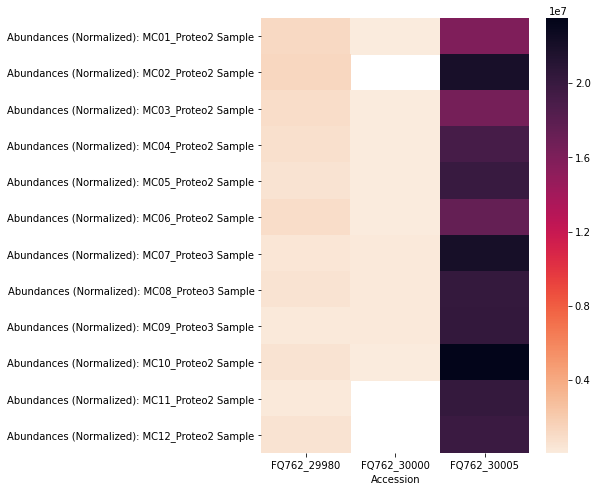

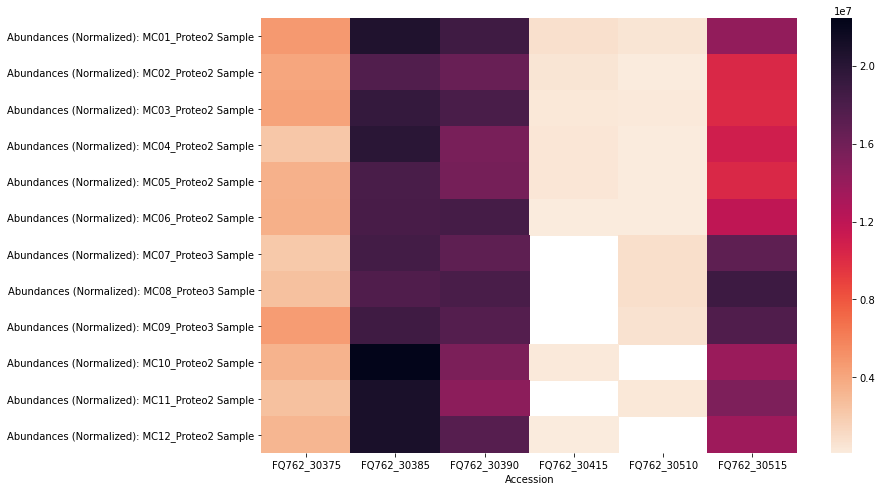

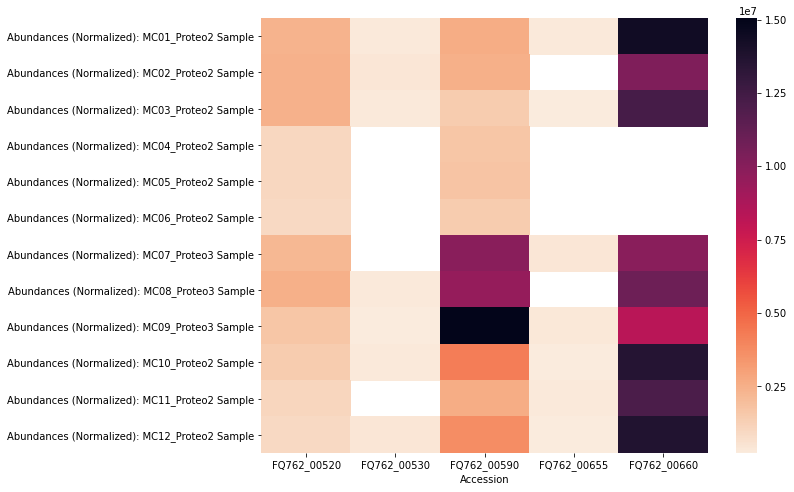

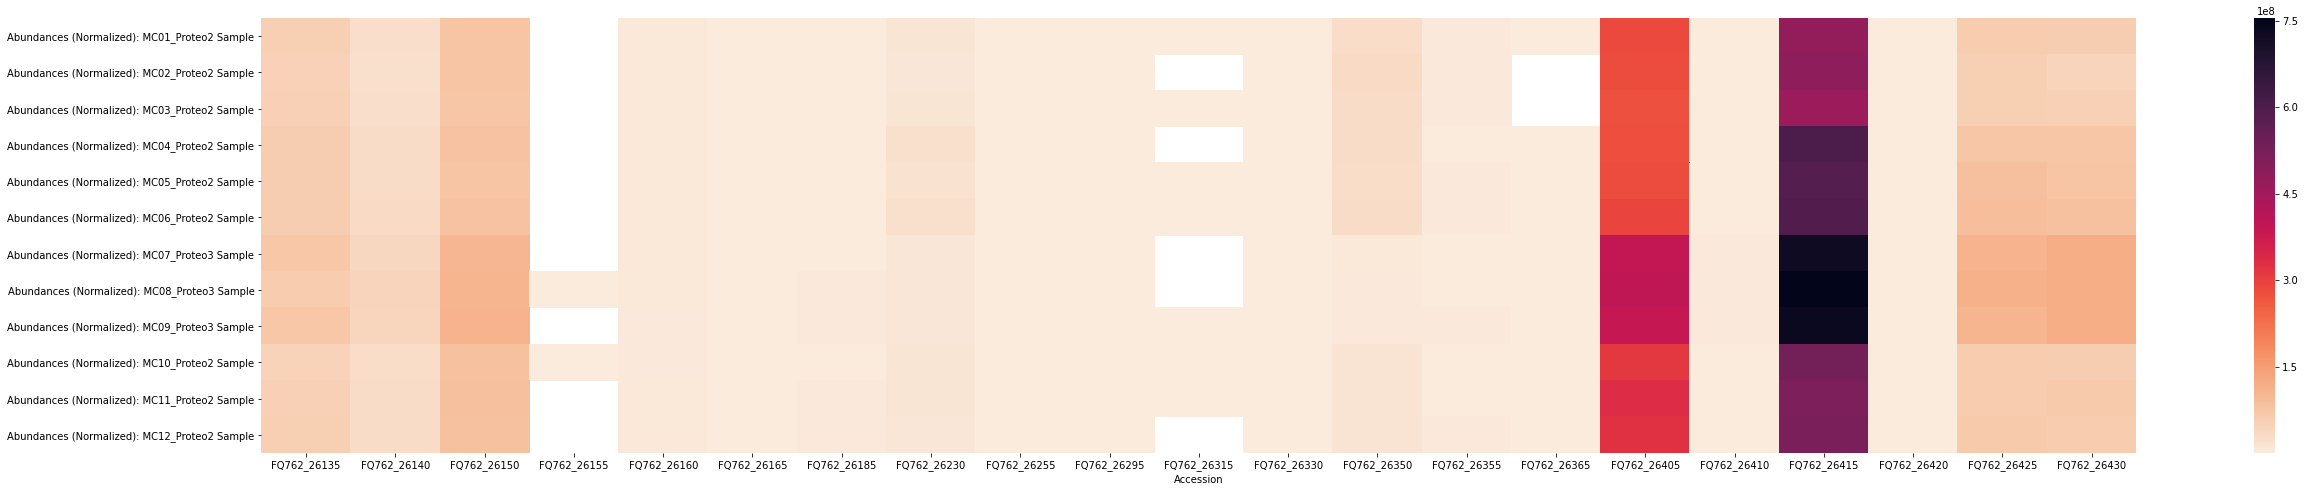

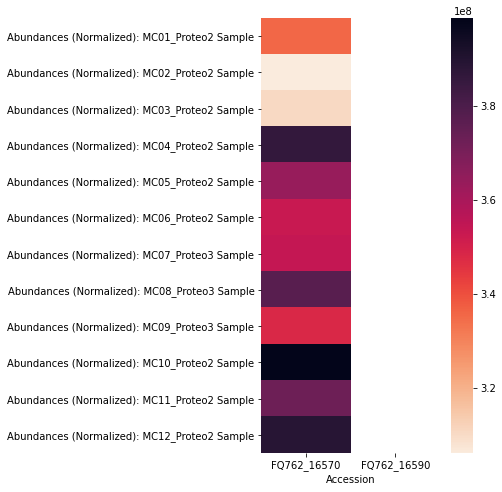

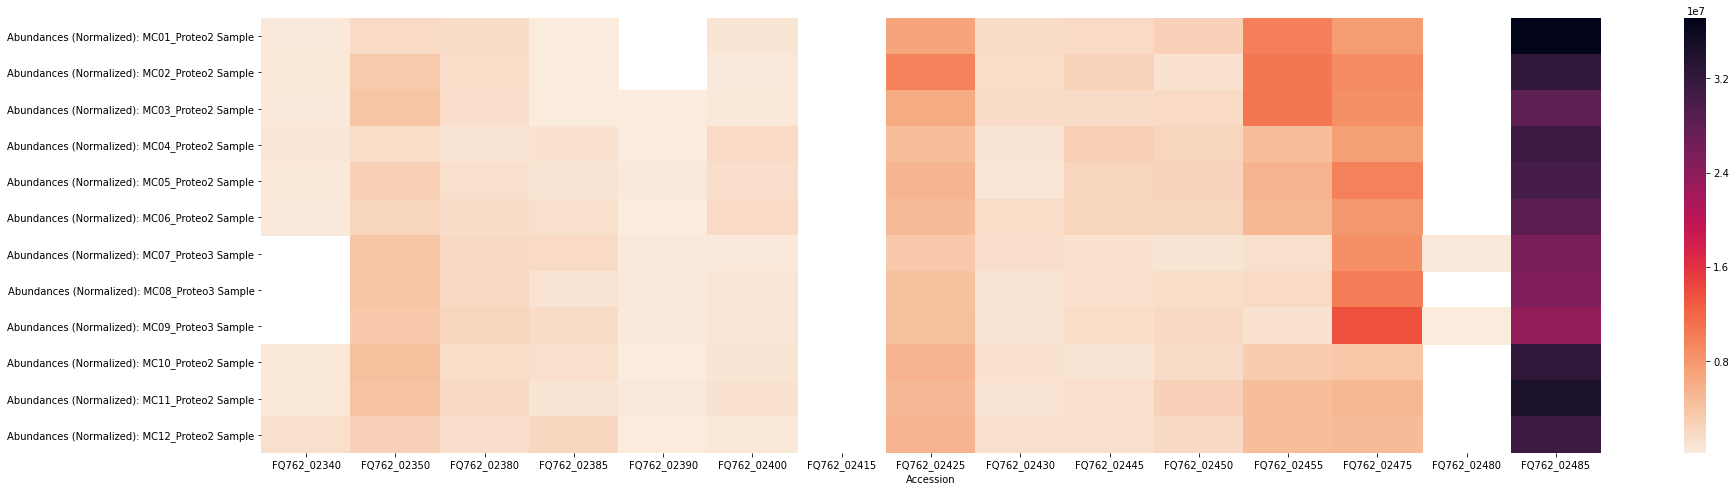

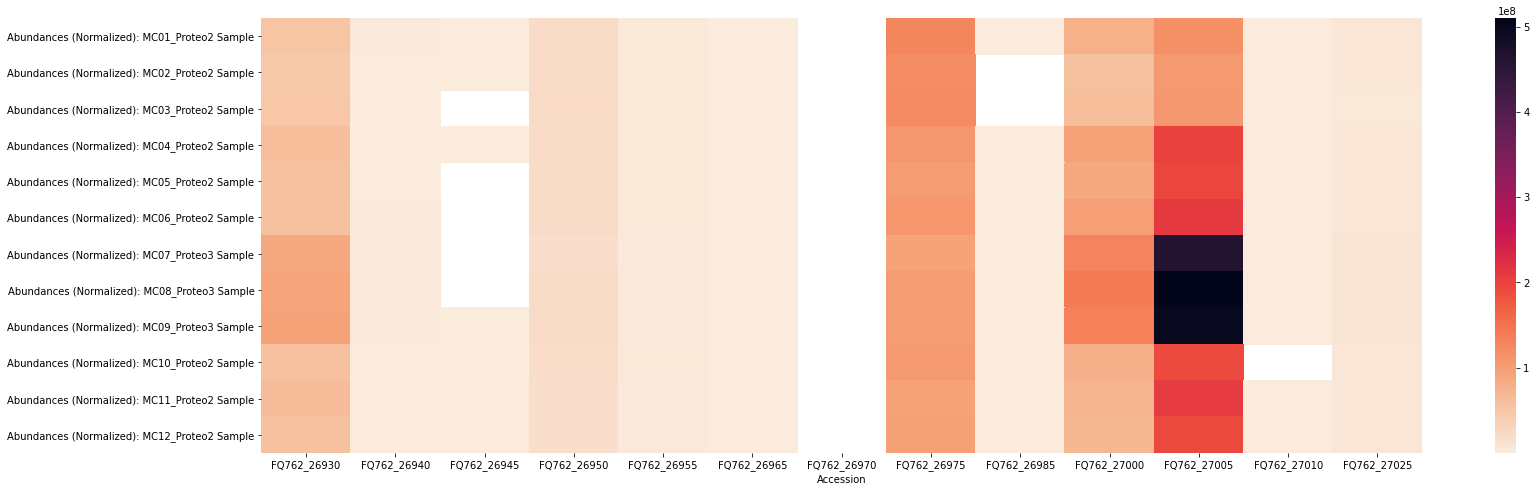

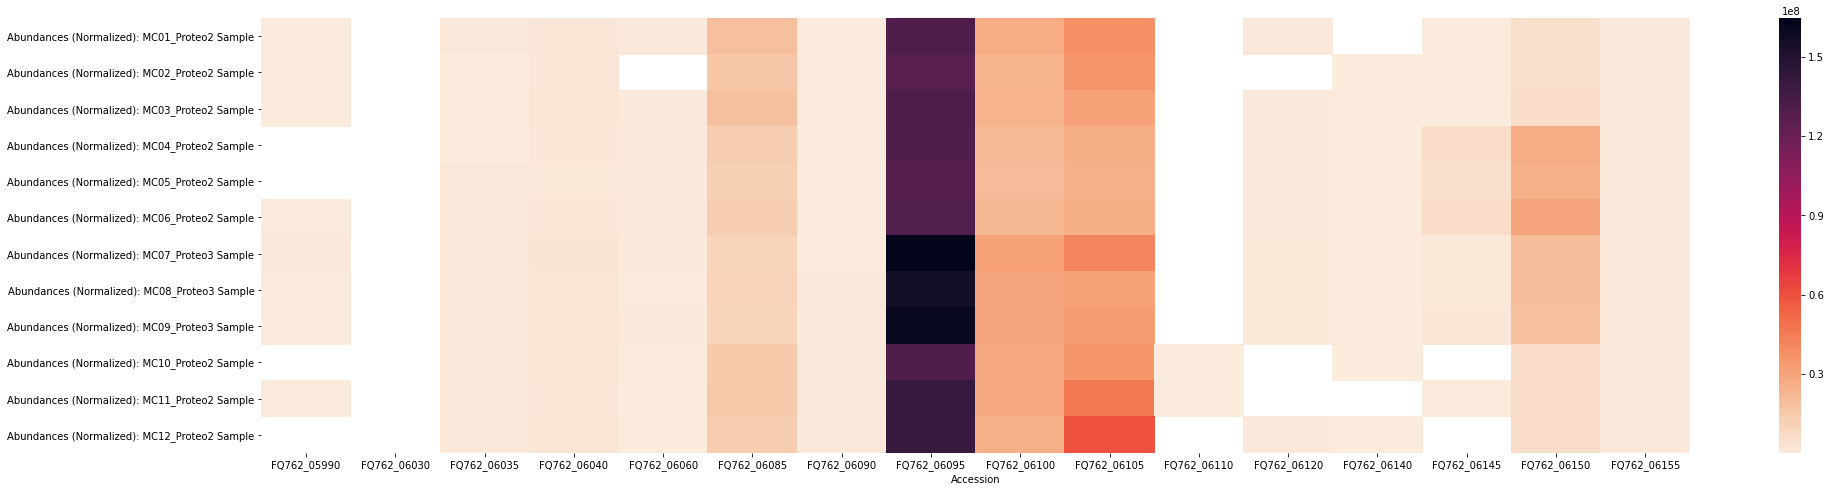

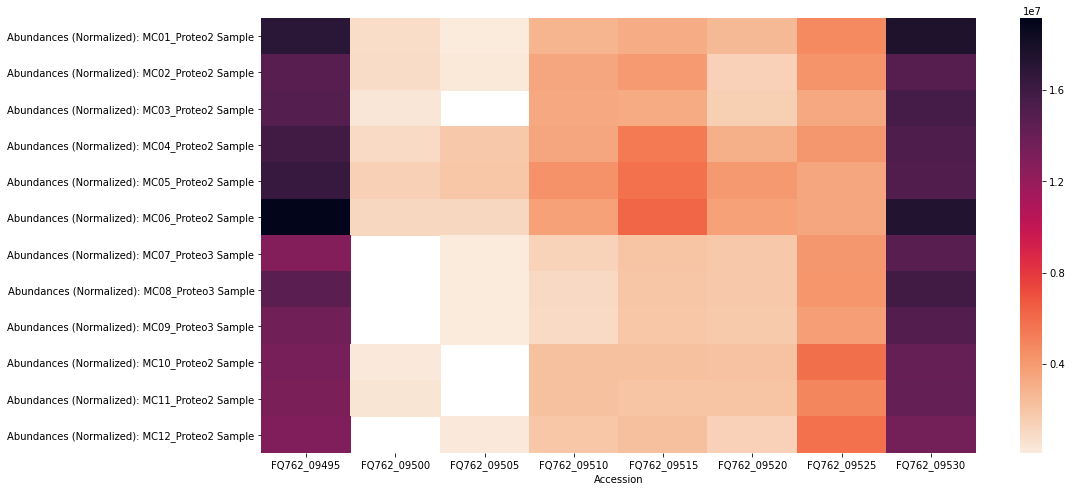

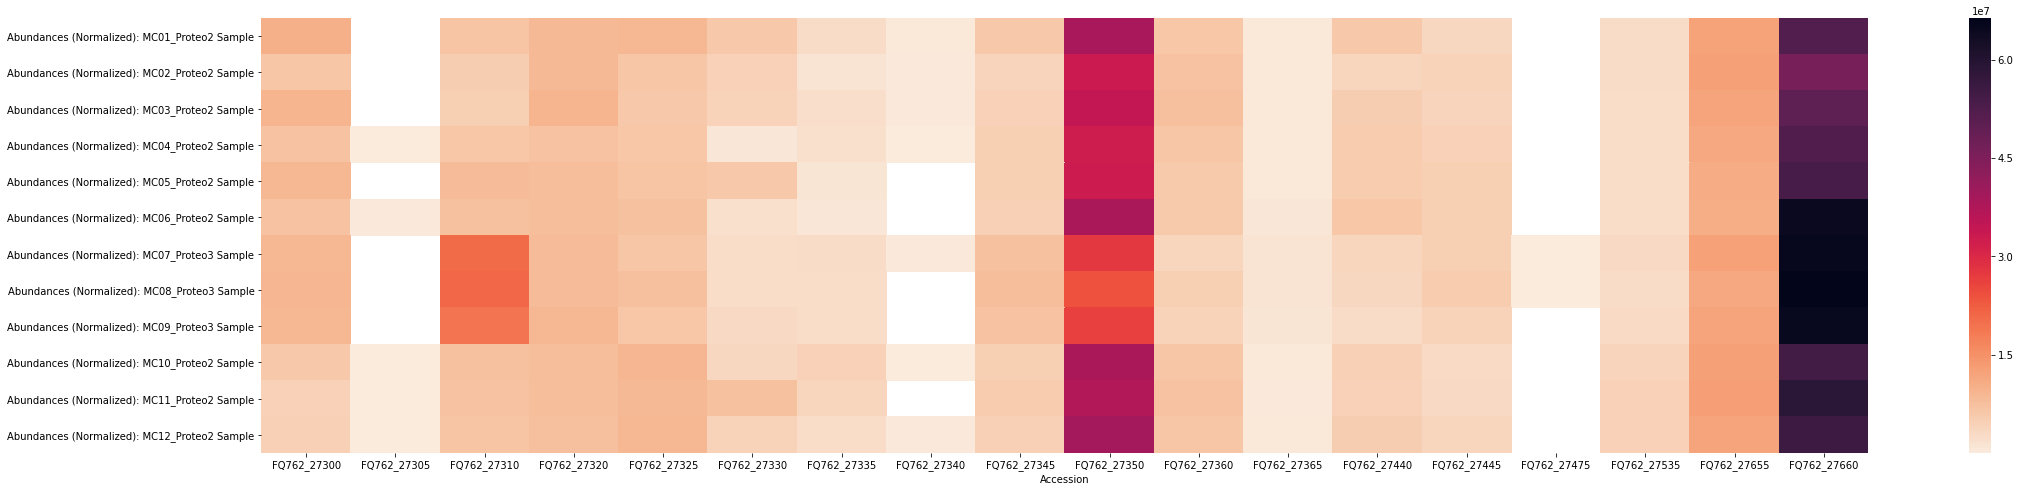

In [154]:
#Extraction of locus tags from antismash cluster files 

#directory containing .gbk region files
#proteome_data = pd.read_excel("/Users/chrwhi/Documents/PhD/Lab/MCBE/OMICS_Data/Proteomics/Prot112_results_01.xlsx")
directory = "/Users/chrwhi/Documents/PhD/Lab/Genomes/antiSMASH_Runs/CFB-NBC0001_Scoelicolor/"


#Extract region file names 
cluster_files = list()
for file in os.listdir(directory):
    if file.endswith(".gbk"):
        if "region" in str(file):
            cluster_files.append(str(file))

#Extract all locus tags from each region gbk and write into a csv file
for entry in cluster_files:
    name = str(entry[:-4])
    with open(directory +name + ".csv","w") as out:
        for record in SeqIO.parse(directory + entry, "genbank"):
            for feature in record.features:
                if feature.type == "CDS":
                    locus_tag = feature.qualifiers.get("locus_tag", ["???"])[0]
                    out.write(locus_tag + "\n")


for file in os.listdir(directory):
    locus_tags = list()
    if file.endswith(".csv"):
        name = str(file[:-4])
        with open(directory + file, "r") as tags:
            for line in tags:
                locus_tags.append(line.strip())
                    
        proteome_data_samples_locustags = proteome_data_samples[proteome_data_samples.index.isin(locus_tags)]
        proteome_data_samples_locustags_transposed = proteome_data_samples_locustags.transpose().sort_index(axis=1).sort_index(axis=0)
        
        #write region results as csv
        #proteome_data_samples_locustags.to_csv(proteomics_dir+"Analysis_BE/"+name+"test.csv")
        #proteome_data_samples_locustags_transposed.to_csv(proteomics_dir+"Analysis_BE/"+name+"transposed"+"test.csv")
      
        #if no matching peptides were found for a region, return notification
        if len(proteome_data_samples_locustags_transposed.columns) == 0:
            print("Dataframe " + name + " is empty!")
            continue
        else:
            #dynamic adjustment of figure size based on number of columns
            width = len(proteome_data_samples_locustags_transposed.columns)
            plt.figure(figsize=(2*width, 8))
            
            ax = sns.heatmap(proteome_data_samples_locustags_transposed, cmap='rocket_r')
            fig = ax.get_figure()
            #save figure
            #fig.savefig(proteomics_dir+"Analysis_BE/Plotting/"+name+"Proteo2_test.jpg",bbox_inches="tight") 